In [60]:
import numpy as np
import pandas as pd
from keras.models import Sequential
from keras.layers import Dense
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import os
import pickle
import time
from keras import backend as K
from sklearn.model_selection import cross_val_score
from sklearn.tree import ExtraTreeRegressor
from sklearn.metrics import r2_score
#from multiprocessing import Pool,cpu_count
import sklearn.metrics as m
from collections import Counter
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.metrics import mean_squared_error,mean_absolute_error
from sklearn.feature_selection import RFE

In [185]:
'''
Function that takes in a dataframe and then returns the dictionary of accuracies.
'''
'r'
req_columns = ["timestamp","air1","furnace1","waterheater1","total"]

def plot_test(y_test,y_pred,start,end):
    #Plot of testing.
    plt.figure(figsize=(10,10))
    plt.plot(y_test[start:end],'r')
    plt.plot(y_pred[start+1:end],'b')
    plt.xticks(np.arange(0,end-start,1))
    plt.legend()
    plt.show()

def coeff_determination(y_true, y_pred):
    SS_res =  K.sum(K.square( y_true-y_pred )) 
    SS_tot = K.sum(K.square( y_pred - K.mean(y_true) ) ) 
    return ( 1 - SS_res/(SS_tot + K.epsilon()) )

def create_df(localdf):
    i=0
    flag=0
    newdf = []
    timestamp = []
    d = np.zeros((7,))
    newhr = []
    
    while(24*(i+1)<localdf.shape[0]):
        #print (np.shape(np.sum(localdf.values[24*i:24*(i+1),1:],axis=0).reshape(7,1)),np.sum(localdf.values[24*i:24*(i+1),1:],axis=0).reshape(7,1))
        d = np.sum(localdf.values[24*i:24*(i+1),1:],axis=0)
        newhr.append(localdf.values[24*i:24*(i+1),-1])
        timestamp.append(localdf.values[24*i,0])
        newdf.append(d.T)
        i += 1
    
    print ("End i: ",i)
    
    newdf = np.hstack((np.reshape(timestamp,(-1,1)),newdf))
    newsum = []
    
    #If the dataframe pertaining to the house-id : 1632 is passed, then do just the following.
    if(localdf.shape[1]>=8):
        print ("Passed the original DataFrame corresponding to the house id : 1632.")
        flag=1
        d = pd.DataFrame(newdf,columns = localdf.columns)  
    
    #If the dataframe passed does not pertain to that of the house-id : 1632.
    if (flag!=1):
        d = pd.DataFrame(newdf,columns=["timestamp","air1","furnace1","waterheater1"])
        d['total_load'] = d["air1"] + d["furnace1"] + d["waterheater1"]
    
    print (d.head())
    newdf = d.values
    
    print (newdf.shape)
    return newdf,newhr
  


def extra_trees(localdf,localdict,times,metric,num_cols,hour_day,full=True,stop=3):
    for counter in range(times):
            i=num_cols
            df = pd.DataFrame()
            #The first column shouldn't be the 'timestamp'.
            if(i != 0):
                #Function returns Day loads and total load also separately
                ndf,nhr = create_df(localdf)
                print ("Inside extra trees : ",ndf.shape)
                if (full==True):
                    ndf = pd.DataFrame(ndf,columns = localdf.columns)
                else:
                    ndf = pd.DataFrame(ndf,columns = req_columns)
                
                #To get the total load of the days
                df = pd.DataFrame(ndf.values[:,-1])
                
                # To collate d1 to d7
                ndf = pd.concat([df.shift(l) for l in range(stop,-1,-1) ],axis=1)
                ndf.columns = [ "t-" + str(j) for j in range(stop,-1,-1) ]
                print ("mean :",ndf[ndf.columns[-1]].mean(),"max:",ndf[ndf.columns[-1]].max(),"min:",ndf[ndf.columns[-1]].min())
                ndf.rename(columns={'t-0':'t'}, inplace=True)
                
                #Adding new features.
                temp = pd.DataFrame()
                temp["dow"] = pd.to_datetime(ndf[ndf.columns[0]]).dt.dayofweek
                temp["month"] = pd.to_datetime(ndf[ndf.columns[0]]).dt.month
                    
                print ("Dimensions of temp : ",temp.shape)
                
                print ("\n\n Dimensions of ndf : ",ndf.shape)
                
                ndf = pd.concat([temp,ndf],axis=1)
                print ("Shape of ndf after merging : ",ndf.shape)
                print (ndf.head())
                
                x = ndf.values[stop:,:-1]  #np.hstack((ndf.values[7:-1],nhr[7:-1]))
                y = ndf.values[stop:,-1]
                
                #Addition of a new feature.
                '''
                temp = pd.DataFrame()
                temp["prev_4_week-days"] = ""
                k=0
                i=27
                while i < (ndf.shape[0]):
                    temp["prev_4_week-days"].values[i] = ndf["t"].values[i-6] + ndf["t"].values[i-13] + ndf["t"].values[i-20] + ndf["t"].values[i-27]
                    print ("Temp : ",temp.head())
                    i += 1
                
                ndf = pd.concat([temp,ndf],axis=1)
                x = ndf.values[27:,:-1] #np.hstack((ndf.values[7:-1],nhr[7:-1]))
                y = ndf.values[27:,-1]
                print ("X : ",x)
                '''
                #print ("\n The DataFrame to be passed to the model. \n",x.head())
                print (x.shape,y.shape)
                print (ndf.describe())
                train_size = int(x.shape[0]*0.7)
                X_train = x[:train_size]
                y_train = y[:train_size]
                
                X_test = x[train_size:]
                y_test = y[train_size:]
                print ("Split done ",X_train.shape,X_test.shape,y_train.shape,y_test.shape)
                
                model=ExtraTreesRegressor(n_estimators=500,max_features=None,verbose=1)
                model.fit(X_train,y_train)
                y_pred = model.predict(X_test)
                
                importances = model.feature_importances_
                std = np.std([tree.feature_importances_ for tree in model.estimators_],
                             axis=0)
                indices = np.argsort(importances)[::-1]

                # Print the feature ranking
                print("Feature ranking according to the ETR : ")

                for f in range(x.shape[1]):
                    print("%d. feature %d (%f)" % (f + 1, indices[f], importances[indices[f]]))

                '''
                Performing feature ranking.
                '''
                
                selector = RFE(model,step = 1)
                selector = selector.fit(x,y)
                print ("Ranking of the features : ",selector.ranking_,"\n\n\n")
                
                
                #The minimum value of y_pred should be '0', it can't go below that, that'd be illogical.
                y_pred[y_pred<0]=0
                
                r2 = r2_score(y_test,y_pred)
                mse = mean_squared_error(y_test,y_pred)
                mae = mean_absolute_error(y_test,y_pred)
                
                print ("R2 Score : ",r2)
                print ("RMSE : ",np.sqrt(mse))
                print ("MAE : ",mae)
                
                localdict["R2"] = r2
                localdict["RMSE"] = np.sqrt(mse)
                localdict["MAE"] = mae       
                
                #Visualize a plot of 'ytest' VS 'ypred'.
                plot_test(y_test,y_pred,0,50)
                
    return localdict,y_test,y_pred  

def nn_model(localdf,localdict,times,metric,num_cols,hour_day,full=True):
    for counter in range(times):
            i=num_cols
            df = pd.DataFrame()
            if(i != 0):
                #Function returns Day loads and total load also separately
                ndf,nhr = create_df(localdf)
                print ("Inside nn : ",ndf.shape)
                
                if (full==True):
                    ndf = pd.DataFrame(ndf,columns = localdf.columns)
                else:
                    ndf = pd.DataFrame(ndf,columns = req_columns)
                
                print (ndf.head())
                #To get the total load of the days
                df = pd.DataFrame(ndf.values[:,-1])
                # To collate d1 to d7
                ndf = pd.concat([df.shift(7),df.shift(6),df.shift(5),df.shift(4),df.shift(3),df.shift(2),df.shift(1),df.shift(0)],axis=1)
                ndf.columns = ('t-7','t-6','t-5','t-4','t-3','t-2','t-1','t')
                print ("mean :",ndf['t'].mean(),"max:",ndf['t'].max(),"min:",ndf['t'].min())
                
                x = ndf.values[7:,:-1] #np.hstack((ndf.values[7:-1],nhr[7:-1]))
                y = ndf.values[7:,-1]
                
                print ("Input Dimensions : ",x.shape,y.shape)
                print (ndf.describe())
                train_size = int(x.shape[0]*0.7)
                X_train = x[:train_size]
                y_train = y[:train_size]
                    
                X_test = x[train_size:]
                y_test = y[train_size:]
                
                print ("Split done ",X_train.shape,X_test.shape,y_train.shape,y_test.shape,)
                
                model = Sequential()
                model.add(Dense(7,input_dim=7,kernel_initializer='normal', activation='relu'))
                #Output Layer.
                model.add(Dense(1,kernel_initializer='normal'))
                #Compile model.
                model.compile(loss='mean_squared_error',optimizer='adam',metrics=[metric])
                #Fit the model.
                history = model.fit(X_train,y_train,epochs=750,verbose=1)
                #Final Evaluation of the model.
                #model.evaluate returns the 'loss' and the 'metrics' for the model.
                scores = model.evaluate(X_test,y_test,verbose=1,batch_size=X_test.shape[0])
                y_pred = model.predict(X_test,batch_size=X_test.shape[0])
                
                y_pred[y_pred<0]=0
                
                r2 = r2_score(y_test[:-1],y_pred[1:])
                mse = mean_squared_error(y_test[:-1],y_pred[1:])
                mae = mean_absolute_error(y_test[:-1],y_pred[1:])
                
                print ("R2 Score : ",r2)
                print ("RMSE : ",np.sqrt(mse))
                print ("MAE : ",mae)
                
                localdict["R2"] = r2
                localdict["RMSE"] = np.sqrt(mse)
                localdict["MAE"] = mae       
                
                #Visualize a plot of 'ytest' VS 'ypred'.
                plot_test(y_test,y_pred,0,50)
                del model
                
    return localdict,y_test,y_pred  

End i:  1700
Passed the original DataFrame corresponding to the house id : 1632.
                localhour      air1      air2 air3 furnace1 furnace2  \
0  2013-03-23 08:00:00-05         0         0    0  142.417  502.533   
1  2013-03-24 08:00:00-05         0         0    0  4182.12  2967.85   
2  2013-03-25 08:00:00-05      0.15  0.383333    0  10421.1  3787.13   
3  2013-03-26 08:00:00-05         0         0    0  5657.58   2665.9   
4  2013-03-27 08:00:00-05  0.133333         0    0     3477  1465.53   

  waterheater1 total_thermal_load  
0      2567.92            3212.87  
1      1473.55            8623.52  
2      5991.67            20200.4  
3      1437.45            9760.93  
4      4167.75            9110.42  
(1700, 8)
Inside extra trees :  (1700, 8)
mean : 14106.0630784 max: 73695.08333333334 min: 552.5999999999999
Dimensions of temp :  (1700, 2)


 Dimensions of ndf :  (1700, 31)
Shape of ndf after merging :  (1700, 33)
   dow  month t-30 t-29 t-28 t-27 t-26 t-25 t-24 t-23

[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    3.2s finished
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.1s finished


Feature ranking according to the ETR : 
1. feature 31 (0.489504)
2. feature 30 (0.081384)
3. feature 29 (0.050612)
4. feature 28 (0.042624)
5. feature 27 (0.034357)
6. feature 26 (0.020864)
7. feature 18 (0.016498)
8. feature 19 (0.015378)
9. feature 25 (0.015027)
10. feature 20 (0.014305)
11. feature 23 (0.013518)
12. feature 24 (0.013279)
13. feature 17 (0.012714)


[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    4.6s finished
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    4.6s finished
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    4.6s finished
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    4.4s finished
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    4.3s finished
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    4.1s finished
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    4.0s finished
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    3.9s finished
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    3.7s finished
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    3.6s finished
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    3.5s finished
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    3.3s finished
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    3.2s finished
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    3.0s finished
[Parallel(n_jobs=1)]

14. feature 15 (0.012490)
15. feature 5 (0.012092)
16. feature 2 (0.011984)
17. feature 21 (0.011591)
18. feature 8 (0.011403)
19. feature 16 (0.011163)
20. feature 4 (0.010964)
21. feature 22 (0.010930)
22. feature 12 (0.010617)
23. feature 13 (0.010460)
24. feature 11 (0.010289)
25. feature 14 (0.010148)
26. feature 6 (0.009999)
27. feature 9 (0.009376)
28. feature 3 (0.009273)
29. feature 7 (0.009160)
30. feature 10 (0.007998)
31. feature 1 (0.000000)
32. feature 0 (0.000000)
Ranking of the features :  [17 16  1 13  5  1 10 14  4 12 15  6  9  1 11  1  8  1  1  1  1  2  3  1  7
  1  1  1  1  1  1  1] 



R2 Score :  0.681198878614
RMSE :  6635.16654164
MAE :  4655.06346633


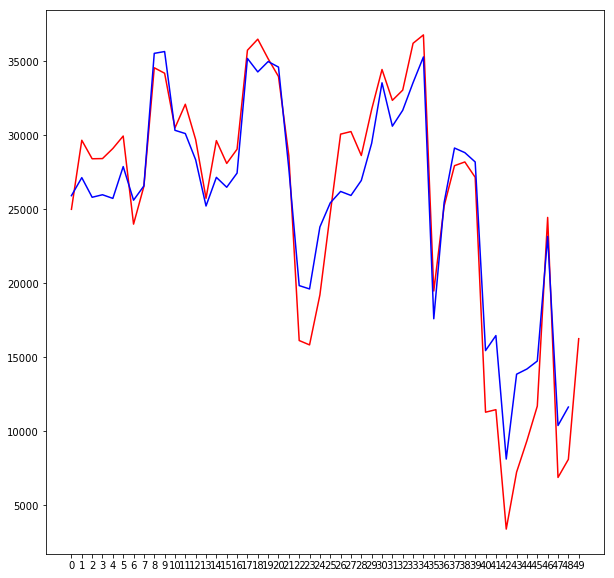


Time Taken :  74.77232146263123

 {'R2': 0.68119887861447326, 'RMSE': 6635.1665416445194, 'MAE': 4655.0634663339988}


In [186]:
'''
Running the extra trees regressor on df_new_thermal, where :
df_new_thermal : full dataframe of house:1632 with consumption in Watt-Hr.
'''
thermal_dict = {}
model_history = {}
ti = time.time()
thermal_dict1,y_test1,y_pred1 = extra_trees(df_new_thermal,thermal_dict,1,"mean_squared_error",7,day_hour,stop=30)
tf = time.time()
print ("\nTime Taken : ",tf-ti)
print ("\n",thermal_dict1)

In [3]:
df= pd.read_pickle("../DataSets/New_Pecan_Street/load_data_1632.pkl")
df_new=df

In [171]:
df_new_thermal[df_new_thermal.columns[-1]].values[5-5]

15.9

In [4]:
pos=[]
for i in range(3,len(df.columns)):
    if (np.sum(np.isnan(df.iloc[:,i].values))>=40995):
        print ('Empty Column')
        pos.append(i)
    else:
        print ('All fine')
        

All fine
All fine
All fine
Empty Column
Empty Column
All fine
Empty Column
Empty Column
Empty Column
Empty Column
Empty Column
Empty Column
Empty Column
All fine
Empty Column
Empty Column
Empty Column
All fine
All fine
All fine
All fine
Empty Column
All fine
All fine
All fine
All fine
Empty Column
All fine
Empty Column
Empty Column
Empty Column
Empty Column
Empty Column
Empty Column
All fine
All fine
All fine
All fine
All fine
Empty Column
Empty Column
Empty Column
Empty Column
Empty Column
All fine
Empty Column
All fine
All fine
Empty Column
Empty Column
Empty Column
Empty Column
Empty Column
Empty Column
Empty Column
All fine
All fine
Empty Column
Empty Column
Empty Column
Empty Column
Empty Column
Empty Column
All fine
Empty Column
Empty Column


In [5]:
df_new.drop(df_new.columns[pos], inplace=True, axis=1)

In [6]:
for i in range(3,len(df.columns)):
    print (df.columns[i], np.sum(np.isnan(df.iloc[:,i].values)))

air1 1
air2 1
air3 18
bathroom1 18
clotheswasher1 0
dishwasher1 0
disposal1 0
drye1 40833
dryg1 162
furnace1 18
furnace2 0
garage1 18
garage2 162
grid 1
kitchenapp1 0
kitchenapp2 0
lights_plugs1 18
lights_plugs2 18
lights_plugs3 40851
microwave1 0
outsidelights_plugs1 1
outsidelights_plugs2 1
range1 40851
refrigerator1 7942
waterheater1 18


In [7]:
nuls={}
l=0
for i in range(3,len(df.columns)):
    a=df.iloc[:,i].values
    b=[]
    for j in range (len(a)):
        if np.isnan(a[j])==1:
            b.append(j)
    string = str(i)+"-"+str(np.sum(np.isnan(a)))
    nuls[string]=b


In [8]:
#After removing the entirely NULL columns.
df.isnull().sum()

dataid                      0
localhour                   0
use                         1
air1                        1
air2                        1
air3                       18
bathroom1                  18
clotheswasher1              0
dishwasher1                 0
disposal1                   0
drye1                   40833
dryg1                     162
furnace1                   18
furnace2                    0
garage1                    18
garage2                   162
grid                        1
kitchenapp1                 0
kitchenapp2                 0
lights_plugs1              18
lights_plugs2              18
lights_plugs3           40851
microwave1                  0
outsidelights_plugs1        1
outsidelights_plugs2        1
range1                  40851
refrigerator1            7942
waterheater1               18
dtype: int64

In [9]:
#Dropping the columns : (1) drye1 (2) lights_plugs3 (3)range1 
df.drop(df.columns[[10,21,25]],inplace=True,axis=1)

In [10]:
#After removing the entirely NULL columns.
df.isnull().sum()

dataid                     0
localhour                  0
use                        1
air1                       1
air2                       1
air3                      18
bathroom1                 18
clotheswasher1             0
dishwasher1                0
disposal1                  0
dryg1                    162
furnace1                  18
furnace2                   0
garage1                   18
garage2                  162
grid                       1
kitchenapp1                0
kitchenapp2                0
lights_plugs1             18
lights_plugs2             18
microwave1                 0
outsidelights_plugs1       1
outsidelights_plugs2       1
refrigerator1           7942
waterheater1              18
dtype: int64

In [11]:
df_thermal = df[['dataid','localhour','air1','air2','air3','furnace1','furnace2','waterheater1']]
#Removing the dataid and the localhour column from df_thermal.
del df_thermal[df_thermal.columns[0]]
print (df_thermal.shape)

(40995, 7)


In [12]:
df_thermal.head()

,localhour,air1,air2,air3,furnace1,furnace2,waterheater1
0,2013-03-15 01:00:00-05,0.0,0.0,0.0,0.049567,0.0,0.0
1,2013-03-15 02:00:00-05,0.0,0.0,0.0,0.048283,0.0,0.0
2,2013-03-15 03:00:00-05,0.0,0.0,0.0,0.089833,0.0,0.0
3,2013-03-15 04:00:00-05,0.0,0.0,0.0,0.047067,0.0,0.0
4,2013-03-15 05:00:00-05,0.0,0.0,0.0,0.046250,0.0,0.0


In [13]:
df_thermal.isnull().sum()

localhour        0
air1             1
air2             1
air3            18
furnace1        18
furnace2         0
waterheater1    18
dtype: int64

In [14]:
df_thermal = pd.DataFrame(df_thermal.values[175:],columns=df_thermal.columns)

In [15]:
df_thermal.isnull().sum()

localhour       0
air1            1
air2            1
air3            0
furnace1        0
furnace2        0
waterheater1    0
dtype: int64

In [16]:
print( df_thermal.iloc[34491:34494])
df_thermal.values[34492][1] = (df_thermal.iloc[34492-24*7+1][1] + df_thermal.iloc[34492+24*7+1][1]) / 2
df_thermal.values[34492][2] = (df_thermal.iloc[34292-24*7+1][2] + df_thermal.iloc[34492+24*7+1][2]) / 2
print(df_thermal.iloc[34316-24*7+1],df_thermal.iloc[34316+24*7+1])

                    localhour air1         air2 air3 furnace1 furnace2  \
34491  2017-02-27 10:00:00-06    0  6.66667e-05    0    0.005    0.005   
34492  2017-02-27 11:00:00-06  NaN          NaN    0    0.005    0.005   
34493  2017-02-27 12:00:00-06    0            0    0    0.005    0.005   

      waterheater1  
34491            0  
34492            0  
34493            0  
localhour       2017-02-13 04:00:00-06
air1                                 0
air2                                 0
air3                                 0
furnace1                         0.005
furnace2                         0.005
waterheater1                         0
Name: 34149, dtype: object localhour       2017-02-27 04:00:00-06
air1                                 0
air2                                 0
air3                                 0
furnace1                         0.005
furnace2                         0.005
waterheater1                         0
Name: 34485, dtype: object


In [17]:
#Make it vectorized
day_hour = np.empty([df_thermal.shape[0],1],dtype="int")
for i in range(df_thermal.shape[0]):
    day_hour[i] = df_thermal.values[i][0][11:13]

In [18]:
day_hour = pd.DataFrame(day_hour)
day_hour.columns = ["Hour of the Day"]

In [19]:
df_thermal['total_thermal_load'] = df_thermal['air1'] + df_thermal['air2'] + df_thermal['air3'] + df_thermal['furnace1'] + df_thermal['furnace2'] + df_thermal['waterheater1']

In [20]:
df_thermal.head()

,localhour,air1,air2,air3,furnace1,furnace2,waterheater1,total_thermal_load
0,2013-03-23 08:00:00-05,0,0,0,0.0059,0.01,0,0.0159
1,2013-03-23 09:00:00-05,0,0,0,0.00491667,0.01,0,0.0149167
2,2013-03-23 10:00:00-05,0,0,0,0.0059,0.0762833,0.181567,0.26375
3,2013-03-23 11:00:00-05,0,0,0,0.0059,0.0760333,1.32477,1.4067
4,2013-03-23 12:00:00-05,0,0,0,0.006,0.01,0,0.016


In [21]:
df_new_thermal = pd.DataFrame(df_thermal,columns=df_thermal.columns)

In [22]:
#Converting 'kwHr' into 'Watt Hour'.
df_new_thermal = df_thermal.copy()
df_new_thermal.iloc[:,[1,2,3,4,5,6,7]] = df_new_thermal.iloc[:,[1,2,3,4,5,6,7]].mul(1000)

In [23]:
#Performing Sanity Check.
df_thermal.head()

,localhour,air1,air2,air3,furnace1,furnace2,waterheater1,total_thermal_load
0,2013-03-23 08:00:00-05,0,0,0,0.0059,0.01,0,0.0159
1,2013-03-23 09:00:00-05,0,0,0,0.00491667,0.01,0,0.0149167
2,2013-03-23 10:00:00-05,0,0,0,0.0059,0.0762833,0.181567,0.26375
3,2013-03-23 11:00:00-05,0,0,0,0.0059,0.0760333,1.32477,1.4067
4,2013-03-23 12:00:00-05,0,0,0,0.006,0.01,0,0.016


In [192]:
#Performing Sanity Check.
df_new_thermal.head()

,localhour,air1,air2,air3,furnace1,furnace2,waterheater1,total_thermal_load
0,2013-03-23 08:00:00-05,0,0,0,5.9,10,0,15.9
1,2013-03-23 09:00:00-05,0,0,0,4.91667,10,0,14.9167
2,2013-03-23 10:00:00-05,0,0,0,5.9,76.2833,181.567,263.75
3,2013-03-23 11:00:00-05,0,0,0,5.9,76.0333,1324.77,1406.7
4,2013-03-23 12:00:00-05,0,0,0,6,10,0,16


In [27]:
new_df1,newhr = create_df(df_new_thermal)
new_df1 = pd.DataFrame(new_df1,columns = df_new_thermal.columns)
newhr = np.array(newhr)
newhr.shape

End i:  1700
Passed the original DataFrame corresponding to the house id : 1632.
                localhour      air1      air2 air3 furnace1 furnace2  \
0  2013-03-23 08:00:00-05         0         0    0  142.417  502.533   
1  2013-03-24 08:00:00-05         0         0    0  4182.12  2967.85   
2  2013-03-25 08:00:00-05      0.15  0.383333    0  10421.1  3787.13   
3  2013-03-26 08:00:00-05         0         0    0  5657.58   2665.9   
4  2013-03-27 08:00:00-05  0.133333         0    0     3477  1465.53   

  waterheater1 total_thermal_load  
0      2567.92            3212.87  
1      1473.55            8623.52  
2      5991.67            20200.4  
3      1437.45            9760.93  
4      4167.75            9110.42  
(1700, 8)


(1700, 24)

In [207]:
newhr

array([[15.9, 14.916666666666666, 263.74999999999994, ..., 16.0,
        15.916666666666666, 527.7166666666666],
       [117.4, 156.63333333333333, 137.25, ..., 1450.3666666666666,
        1942.8833333333332, 1048.2666666666667],
       [2774.5333333333333, 1729.2333333333333, 255.8833333333333, ...,
        2815.016666666667, 2872.4999999999995, 1612.6000000000001],
       ..., 
       [10.166666666666668, 10.083333333333332, 9.983333333333334, ...,
        10.0, 10.0, 10.166666666666668],
       [10.0, 423.5333333333333, 10.0, ..., 10.0, 10.0, 10.200000000000001],
       [10.0, 10.249999999999998, 10.0, ..., 10.0, 10.0, 10.216666666666665]], dtype=object)

In [29]:
#Sanity Check.
new_df1.head()

#Extracting only the 'air1', 'furnace1' and 'waterheater1' features.
new_df1 = new_df1[["localhour","air1","furnace1","waterheater1"]]
new_df1["total_thermal_load"] = new_df1["air1"] + new_df1["furnace1"] + new_df1["waterheater1"]
new_df1.head()

,localhour,air1,furnace1,waterheater1,total_thermal_load
0,2013-03-23 08:00:00-05,0,142.417,2567.92,2710.33
1,2013-03-24 08:00:00-05,0,4182.12,1473.55,5655.67
2,2013-03-25 08:00:00-05,0.15,10421.1,5991.67,16412.9
3,2013-03-26 08:00:00-05,0,5657.58,1437.45,7095.03
4,2013-03-27 08:00:00-05,0.133333,3477,4167.75,7644.88



Year :  2013

Month :  Jan
Number of days present :  92
From the loop :  (2209, 8)
End i:  92
Passed the original DataFrame corresponding to the house id : 1632.
                localhour     air1     air2 air3 furnace1 furnace2  \
0  2013-10-01 00:00:00-05    10790  1760.07    0  119.417   674.25   
1  2013-10-02 00:00:00-05  9973.63  2143.07    0    119.1  751.883   
2  2013-10-03 00:00:00-05  11358.4  5824.18    0   117.25  1681.02   
3  2013-10-04 00:00:00-05  11841.2  4299.12    0   117.95  1284.53   
4  2013-10-05 00:00:00-05  5842.32   415.55    0  119.867  331.883   

  waterheater1 total_thermal_load  
0      770.317              14114  
1      780.867            13768.5  
2      389.333            19370.2  
3      764.817            18307.6  
4      1154.92            7864.53  
(92, 8)
Inside extra trees :  (92, 8)
mean : 12262.0382246 max: 68297.81666666668 min: 1103.9166666666667
Dimensions of temp :  (92, 2)


 Dimensions of ndf :  (92, 4)
Shape of ndf after merging :  (9

[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.0s finished


Feature ranking according to the ETR : 
1. feature 4 (0.752557)
2. feature 3 (0.154002)
3. feature 2 (0.093441)
4. feature 1 (0.000000)
5. feature 0 (0.000000)


[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.1s finished
/opt/anaconda/lib/python3.6/site-packages/matplotlib/axes/_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


Ranking of the features :  [4 3 2 1 1] 



R2 Score :  0.276118399886
RMSE :  13792.2975158
MAE :  10095.5199247


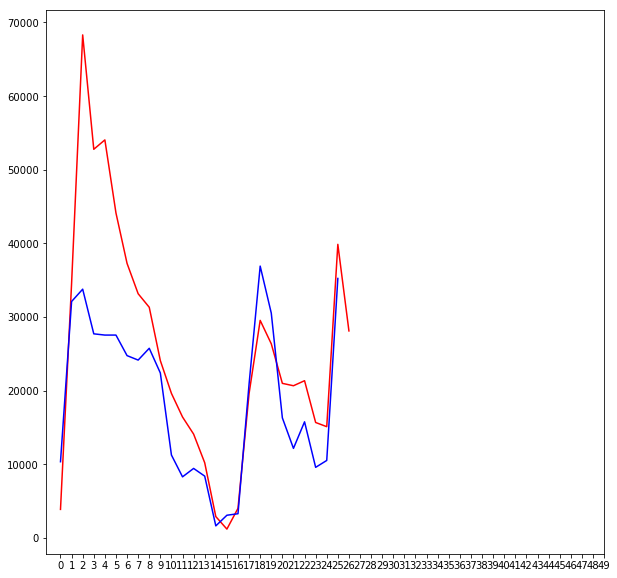


Time Taken :  3.0811517238616943

 {'R2': 0.2761183998855391, 'RMSE': 13792.297515774892, 'MAE': 10095.519924691358}

Year :  2013

Month :  Feb
Number of days present :  0

Year :  2013

Month :  Mar
Number of days present :  0

Year :  2013

Month :  Apr
Number of days present :  0

Year :  2013

Month :  May
Number of days present :  0

Year :  2013

Month :  Jun
Number of days present :  0

Year :  2013

Month :  Jul
Number of days present :  0

Year :  2013

Month :  Aug
Number of days present :  0

Year :  2013

Month :  Sept
Number of days present :  0

Year :  2013

Month :  Oct
Number of days present :  31
From the loop :  (744, 8)
End i:  30
Passed the original DataFrame corresponding to the house id : 1632.
                localhour     air1     air2 air3 furnace1 furnace2  \
0  2013-10-01 00:00:00-05    10790  1760.07    0  119.417   674.25   
1  2013-10-02 00:00:00-05  9973.63  2143.07    0    119.1  751.883   
2  2013-10-03 00:00:00-05  11358.4  5824.18    0   117.25  16

[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.0s finished


 min: 1103.9166666666667
Dimensions of temp :  (30, 2)


 Dimensions of ndf :  (30, 4)
Shape of ndf after merging :  (30, 6)
   dow  month      t-3      t-2      t-1        t
0  NaN    NaN      NaN      NaN      NaN    14114
1  NaN    NaN      NaN      NaN    14114  13768.5
2  NaN    NaN      NaN    14114  13768.5  19370.2
3  3.0    1.0    14114  13768.5  19370.2  18307.6
4  3.0    1.0  13768.5  19370.2  18307.6  7864.53
(27, 5) (27,)
        dow  month
count  27.0   27.0
mean    3.0    1.0
std     0.0    0.0
min     3.0    1.0
25%     3.0    1.0
50%     3.0    1.0
75%     3.0    1.0
max     3.0    1.0
Split done  (18, 5) (9, 5) (18,) (9,)
Feature ranking according to the ETR : 
1. feature 4 (0.765077)
2. feature 2 (0.122377)
3. feature 3 (0.112546)
4. feature 1 (0.000000)
5. feature 0 (0.000000)


[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.1s finished
/opt/anaconda/lib/python3.6/site-packages/matplotlib/axes/_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


Ranking of the features :  [4 3 2 1 1] 



R2 Score :  -14.1428176292
RMSE :  6276.86301769
MAE :  3315.45647037


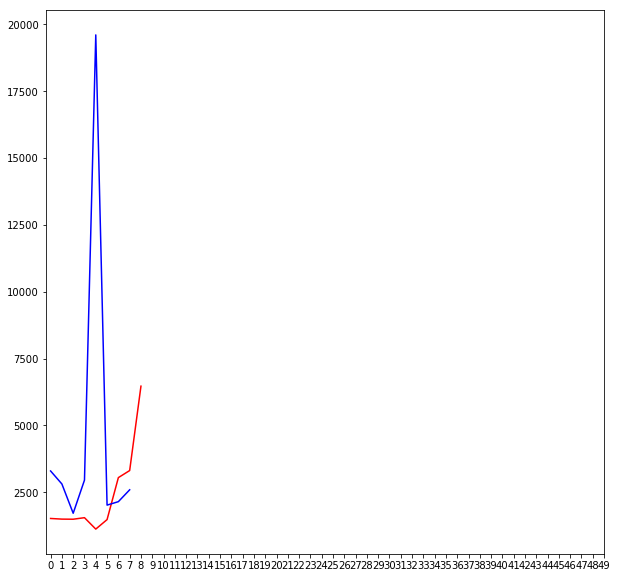


Time Taken :  2.7170937061309814

 {'R2': -14.142817629184741, 'RMSE': 6276.8630176911711, 'MAE': 3315.4564703703772}

Year :  2013

Month :  Nov
Number of days present :  30
From the loop :  (721, 8)
End i:  30
Passed the original DataFrame corresponding to the house id : 1632.
                localhour      air1      air2     air3 furnace1 furnace2  \
0  2013-11-01 00:00:00-05         0       0.1      1.7  120.283   226.95   
1  2013-11-02 00:00:00-05  0.133333  0.383333     1.65    120.6  232.117   
2  2013-11-03 00:00:00-05         0  0.383333  1.78333    120.3  226.517   
3  2013-11-03 23:00:00-06   1.16667       1.8  2.28333  119.983  227.783   
4  2013-11-04 23:00:00-06      0.05  0.166667      1.1  119.917  227.767   

  waterheater1 total_thermal_load  
0      1167.22            1516.25  
1      1150.97            1505.85  
2      1163.63            1512.62  
3      1539.28             1892.3  
4      796.233            1145.23  
(30, 8)
Inside extra trees : 

[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.0s finished


 (30, 8)
mean : 8002.29555556 max: 38661.46666666667 min: 1127.8333333333333
Dimensions of temp :  (30, 2)


 Dimensions of ndf :  (30, 4)
Shape of ndf after merging :  (30, 6)
   dow  month      t-3      t-2      t-1        t
0  NaN    NaN      NaN      NaN      NaN  1516.25
1  NaN    NaN      NaN      NaN  1516.25  1505.85
2  NaN    NaN      NaN  1516.25  1505.85  1512.62
3  3.0    1.0  1516.25  1505.85  1512.62   1892.3
4  3.0    1.0  1505.85  1512.62   1892.3  1145.23
(27, 5) (27,)
        dow  month
count  27.0   27.0
mean    3.0    1.0
std     0.0    0.0
min     3.0    1.0
25%     3.0    1.0
50%     3.0    1.0
75%     3.0    1.0
max     3.0    1.0
Split done  (18, 5) (9, 5) (18,) (9,)
Feature ranking according to the ETR : 
1. feature 4 (0.431839)
2. feature 2 (0.392137)
3. feature 3 (0.176024)
4. feature 1 (0.000000)
5. feature 0 (0.000000)


[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.1s finished
/opt/anaconda/lib/python3.6/site-packages/matplotlib/axes/_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


Ranking of the features :  [4 3 2 1 1] 



R2 Score :  -2.38441657597
RMSE :  21611.0747262
MAE :  18170.2464407


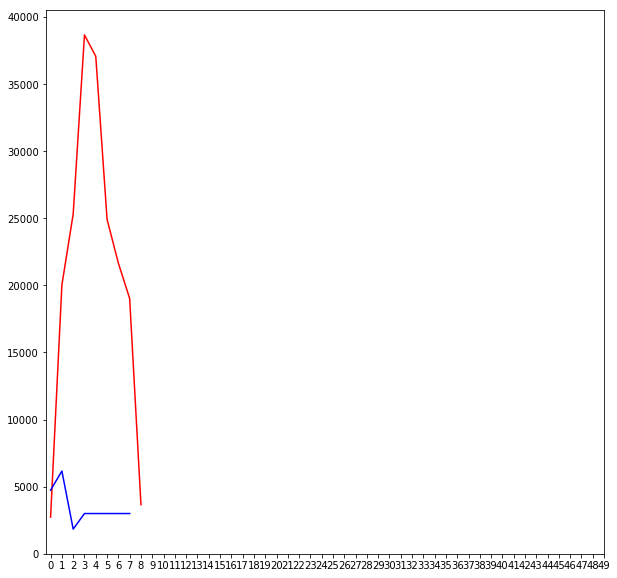


Time Taken :  2.8290631771087646

 {'R2': -2.3844165759662785, 'RMSE': 21611.074726171086, 'MAE': 18170.246440740735}

Year :  2013

Month :  Dec
Number of days present :  31
From the loop :  (744, 8)
End i:  30
Passed the original DataFrame corresponding to the house id : 1632.
                localhour      air1      air2     air3 furnace1 furnace2  \
0  2013-12-01 00:00:00-06      0.05      0.15  2.06667  120.583  1104.47   
1  2013-12-02 00:00:00-06      0.15  0.866667     1.85  120.233    557.9   
2  2013-12-03 00:00:00-06       0.2  0.933333  1.76667    120.3  700.683   
3  2013-12-04 00:00:00-06  0.816667   1.21667      1.8    119.9  230.583   
4  2013-12-05 00:00:00-06      0.35   1.76667     2.85   1435.9   1967.6   

  waterheater1 total_thermal_load  
0      1185.88             2413.2  
1      1189.35            1870.35  
2      1104.93            1928.82  
3      1245.28             1599.6  
4      1559.55            4968.02  
(30, 8)
Inside extra trees :  (30, 8)
mean : 2

[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.0s finished


Dimensions of temp :  (30, 2)


 Dimensions of ndf :  (30, 4)
Shape of ndf after merging :  (30, 6)
   dow  month      t-3      t-2      t-1        t
0  NaN    NaN      NaN      NaN      NaN   2413.2
1  NaN    NaN      NaN      NaN   2413.2  1870.35
2  NaN    NaN      NaN   2413.2  1870.35  1928.82
3  3.0    1.0   2413.2  1870.35  1928.82   1599.6
4  3.0    1.0  1870.35  1928.82   1599.6  4968.02
(27, 5) (27,)
        dow  month
count  27.0   27.0
mean    3.0    1.0
std     0.0    0.0
min     3.0    1.0
25%     3.0    1.0
50%     3.0    1.0
75%     3.0    1.0
max     3.0    1.0
Split done  (18, 5) (9, 5) (18,) (9,)
Feature ranking according to the ETR : 
1. feature 4 (0.663411)
2. feature 3 (0.190524)
3. feature 2 (0.146065)
4. feature 1 (0.000000)
5. feature 0 (0.000000)


[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.1s finished
/opt/anaconda/lib/python3.6/site-packages/matplotlib/axes/_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


Ranking of the features :  [4 3 2 1 1] 



R2 Score :  -1.43580562733
RMSE :  11216.9436456
MAE :  7417.82112222


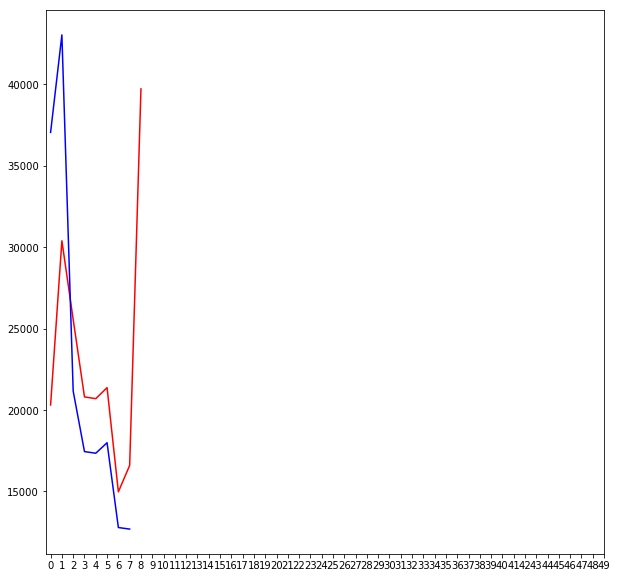


Time Taken :  2.7418901920318604

 {'R2': -1.4358056273342603, 'RMSE': 11216.943645574411, 'MAE': 7417.8211222221535}

Year :  2014

Month :  Jan
Number of days present :  92
From the loop :  (2209, 8)
End i:  92
Passed the original DataFrame corresponding to the house id : 1632.
                localhour       air1      air2     air3 furnace1 furnace2  \
0  2014-10-01 00:00:00-05    10179.1    2929.4  2869.75  687.683   500.25   
1  2014-10-02 00:00:00-05    9471.15   1819.18  3039.27    720.2    348.4   
2  2014-10-03 00:00:00-05    1723.65       1.7   984.35    331.5  119.133   
3  2014-10-04 00:00:00-05  0.0666667  0.633333      1.6   120.25  119.983   
4  2014-10-05 00:00:00-05    2226.82       0.4  164.017  155.617  118.867   

  waterheater1 total_thermal_load  
0        822.6            17988.8  
1      805.383            16203.6  
2      814.117            3974.45  
3      1148.08            1390.62  
4        800.2            3465.92  
(92, 8)
Inside extra trees :  (92, 8)
m

[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.0s finished





 Dimensions of ndf :  (92, 4)
Shape of ndf after merging :  (92, 6)
   dow  month      t-3      t-2      t-1        t
0  NaN    NaN      NaN      NaN      NaN  17988.8
1  NaN    NaN      NaN      NaN  17988.8  16203.6
2  NaN    NaN      NaN  17988.8  16203.6  3974.45
3  3.0    1.0  17988.8  16203.6  3974.45  1390.62
4  3.0    1.0  16203.6  3974.45  1390.62  3465.92
(89, 5) (89,)
        dow  month
count  89.0   89.0
mean    3.0    1.0
std     0.0    0.0
min     3.0    1.0
25%     3.0    1.0
50%     3.0    1.0
75%     3.0    1.0
max     3.0    1.0
Split done  (62, 5) (27, 5) (62,) (27,)
Feature ranking according to the ETR : 
1. feature 4 (0.727107)
2. feature 3 (0.167284)
3. feature 2 (0.105610)
4. feature 1 (0.000000)
5. feature 0 (0.000000)


[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.1s finished
/opt/anaconda/lib/python3.6/site-packages/matplotlib/axes/_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


Ranking of the features :  [4 3 2 1 1] 



R2 Score :  0.285001223384
RMSE :  4574.84912046
MAE :  2634.49417407


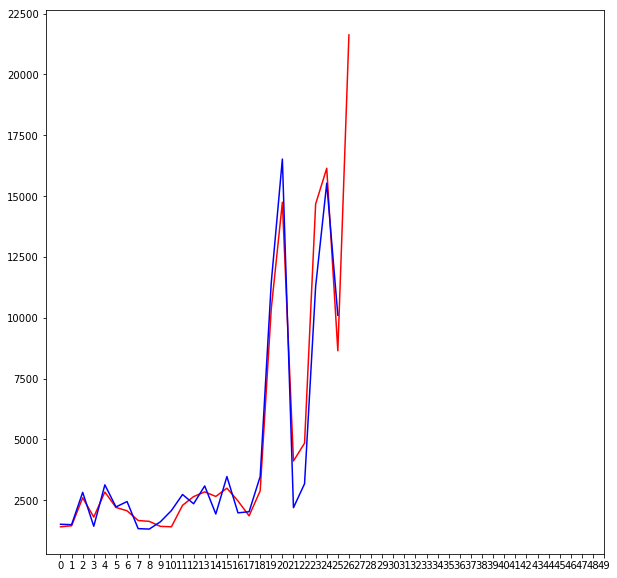


Time Taken :  3.0552098751068115

 {'R2': 0.28500122338365164, 'RMSE': 4574.8491204634729, 'MAE': 2634.4941740740787}

Year :  2014

Month :  Feb
Number of days present :  0

Year :  2014

Month :  Mar
Number of days present :  0

Year :  2014

Month :  Apr
Number of days present :  0

Year :  2014

Month :  May
Number of days present :  0

Year :  2014

Month :  Jun
Number of days present :  0

Year :  2014

Month :  Jul
Number of days present :  0

Year :  2014

Month :  Aug
Number of days present :  0

Year :  2014

Month :  Sept
Number of days present :  0

Year :  2014

Month :  Oct
Number of days present :  31
From the loop :  (744, 8)
End i:  30
Passed the original DataFrame corresponding to the house id : 1632.
                localhour       air1      air2     air3 furnace1 furnace2  \
0  2014-10-01 00:00:00-05    10179.1    2929.4  2869.75  687.683   500.25   
1  2014-10-02 00:00:00-05    9471.15   1819.18  3039.27    720.2    348.4   
2  2014-10-03 00:00:00-05    1723.65   

[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.0s finished



Dimensions of temp :  (30, 2)


 Dimensions of ndf :  (30, 4)
Shape of ndf after merging :  (30, 6)
   dow  month      t-3      t-2      t-1        t
0  NaN    NaN      NaN      NaN      NaN  17988.8
1  NaN    NaN      NaN      NaN  17988.8  16203.6
2  NaN    NaN      NaN  17988.8  16203.6  3974.45
3  3.0    1.0  17988.8  16203.6  3974.45  1390.62
4  3.0    1.0  16203.6  3974.45  1390.62  3465.92
(27, 5) (27,)
        dow  month
count  27.0   27.0
mean    3.0    1.0
std     0.0    0.0
min     3.0    1.0
25%     3.0    1.0
50%     3.0    1.0
75%     3.0    1.0
max     3.0    1.0
Split done  (18, 5) (9, 5) (18,) (9,)
Feature ranking according to the ETR : 
1. feature 4 (0.702648)
2. feature 3 (0.168648)
3. feature 2 (0.128705)
4. feature 1 (0.000000)
5. feature 0 (0.000000)


[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.1s finished
/opt/anaconda/lib/python3.6/site-packages/matplotlib/axes/_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


Ranking of the features :  [4 3 2 1 1] 



R2 Score :  -9.59253034163
RMSE :  1362.09164724
MAE :  1079.8769963


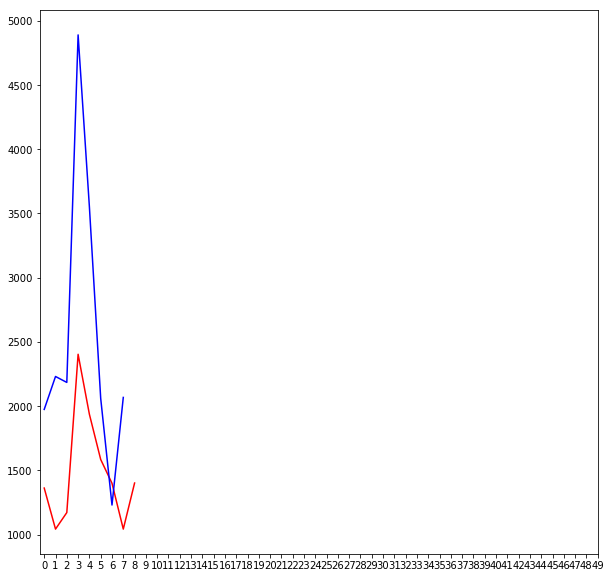


Time Taken :  2.7578628063201904

 {'R2': -9.5925303416304608, 'RMSE': 1362.0916472401034, 'MAE': 1079.8769962962924}

Year :  2014

Month :  Nov
Number of days present :  30
From the loop :  (721, 8)
End i:  30
Passed the original DataFrame corresponding to the house id : 1632.
                localhour  air1       air2     air3 furnace1 furnace2  \
0  2014-11-01 00:00:00-05  0.25    1.06667  2.43333  120.283    120.1   
1  2014-11-02 00:00:00-05  0.05  0.0666667  1.83333   120.25  120.033   
2  2014-11-02 23:00:00-06  0.05        0.8  1.88333  120.183  120.067   
3  2014-11-03 23:00:00-06     0   0.333333  1.93333  120.267  119.783   
4  2014-11-04 23:00:00-06  0.05   0.216667      2.2   120.05  119.917   

  waterheater1 total_thermal_load  
0      1550.65            1794.78  
1      1161.33            1403.57  
2      1182.82             1425.8  
3      1193.95            1436.27  
4       1152.8            1395.23  
(30, 8)


[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.0s finished


Inside extra trees :  (30, 8)
mean : 2346.94 max: 5366.916666666667 min: 1065.6499999999999
Dimensions of temp :  (30, 2)


 Dimensions of ndf :  (30, 4)
Shape of ndf after merging :  (30, 6)
   dow  month      t-3      t-2      t-1        t
0  NaN    NaN      NaN      NaN      NaN  1794.78
1  NaN    NaN      NaN      NaN  1794.78  1403.57
2  NaN    NaN      NaN  1794.78  1403.57   1425.8
3  3.0    1.0  1794.78  1403.57   1425.8  1436.27
4  3.0    1.0  1403.57   1425.8  1436.27  1395.23
(27, 5) (27,)
        dow  month
count  27.0   27.0
mean    3.0    1.0
std     0.0    0.0
min     3.0    1.0
25%     3.0    1.0
50%     3.0    1.0
75%     3.0    1.0
max     3.0    1.0
Split done  (18, 5) (9, 5) (18,) (9,)
Feature ranking according to the ETR : 
1. feature 4 (0.725382)
2. feature 3 (0.146470)
3. feature 2 (0.128148)
4. feature 1 (0.000000)
5. feature 0 (0.000000)


[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.1s finished
/opt/anaconda/lib/python3.6/site-packages/matplotlib/axes/_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


Ranking of the features :  [4 3 2 1 1] 



R2 Score :  -2.48873009866
RMSE :  1218.65464009
MAE :  981.990955556


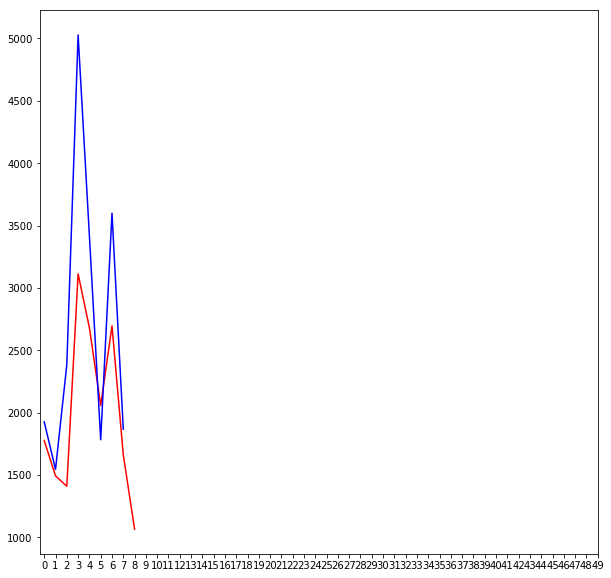


Time Taken :  2.8144450187683105

 {'R2': -2.4887300986604264, 'RMSE': 1218.6546400882853, 'MAE': 981.99095555555891}

Year :  2014

Month :  Dec
Number of days present :  31
From the loop :  (744, 8)
End i:  30
Passed the original DataFrame corresponding to the house id : 1632.
                localhour      air1      air2     air3 furnace1 furnace2  \
0  2014-12-01 00:00:00-06       0.1      0.35  2.93333  120.467    209.7   
1  2014-12-02 00:00:00-06       0.1  0.133333  2.93333  120.067   2386.1   
2  2014-12-03 00:00:00-06  0.166667  0.433333  2.81667   120.35  1193.77   
3  2014-12-04 00:00:00-06       0.2  0.966667  2.13333   120.05  441.417   
4  2014-12-05 00:00:00-06         0  0.933333     1.85    120.2  119.917   

  waterheater1 total_thermal_load  
0      1594.93            1928.48  
1      1507.77             4017.1  
2      1504.82            2822.35  
3      1150.23               1715  
4      1169.23            1412.13  
(30, 8)
Inside extra trees :  (30, 8)
mean : 4

[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.0s finished



Dimensions of temp :  (30, 2)


 Dimensions of ndf :  (30, 4)
Shape of ndf after merging :  (30, 6)
   dow  month      t-3      t-2      t-1        t
0  NaN    NaN      NaN      NaN      NaN  1928.48
1  NaN    NaN      NaN      NaN  1928.48   4017.1
2  NaN    NaN      NaN  1928.48   4017.1  2822.35
3  3.0    1.0  1928.48   4017.1  2822.35     1715
4  3.0    1.0   4017.1  2822.35     1715  1412.13
(27, 5) (27,)
        dow  month
count  27.0   27.0
mean    3.0    1.0
std     0.0    0.0
min     3.0    1.0
25%     3.0    1.0
50%     3.0    1.0
75%     3.0    1.0
max     3.0    1.0
Split done  (18, 5) (9, 5) (18,) (9,)
Feature ranking according to the ETR : 
1. feature 4 (0.394976)
2. feature 2 (0.345013)
3. feature 3 (0.260011)
4. feature 1 (0.000000)
5. feature 0 (0.000000)


[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.1s finished
/opt/anaconda/lib/python3.6/site-packages/matplotlib/axes/_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


Ranking of the features :  [4 3 2 1 1] 



R2 Score :  -1.53923996037
RMSE :  8298.92557932
MAE :  6717.6900963


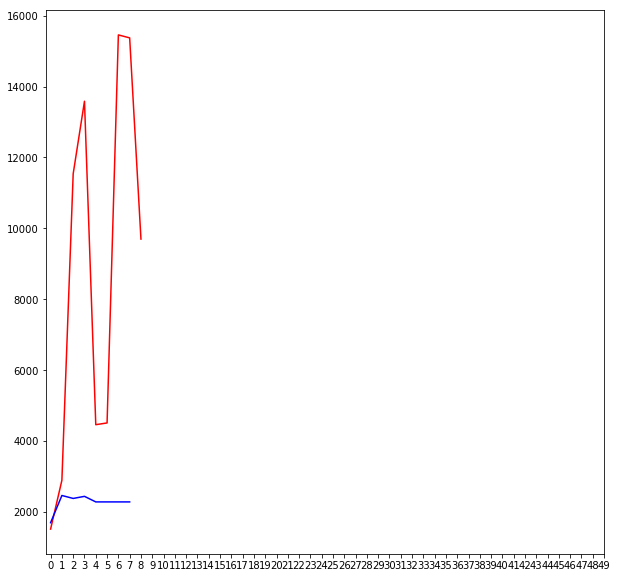


Time Taken :  2.7579238414764404

 {'R2': -1.5392399603734175, 'RMSE': 8298.9255793168195, 'MAE': 6717.6900962962991}

Year :  2015

Month :  Jan
Number of days present :  92
From the loop :  (2209, 8)
End i:  92
Passed the original DataFrame corresponding to the house id : 1632.
                localhour     air1      air2     air3 furnace1 furnace2  \
0  2015-10-01 00:00:00-05  8420.45   5661.58  6985.62  1377.83  822.467   
1  2015-10-02 00:00:00-05  4500.18   347.933  6011.55  1373.43    168.5   
2  2015-10-03 00:00:00-05        0   12.4333  2282.32    584.8  121.767   
3  2015-10-04 00:00:00-05      0.1   1.31667  3296.93  765.367    119.7   
4  2015-10-05 00:00:00-05        0  0.683333  5969.47   1407.8  119.933   

  waterheater1 total_thermal_load  
0      1805.08              25073  
1      1358.78            13760.4  
2      2167.67            5168.98  
3      2380.57            6563.98  
4      3001.07            10498.9  
(92, 8)
Inside extra trees :  (92, 8)
mean : 11858.

[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.0s finished


(92, 6)
   dow  month      t-3      t-2      t-1        t
0  NaN    NaN      NaN      NaN      NaN    25073
1  NaN    NaN      NaN      NaN    25073  13760.4
2  NaN    NaN      NaN    25073  13760.4  5168.98
3  3.0    1.0    25073  13760.4  5168.98  6563.98
4  3.0    1.0  13760.4  5168.98  6563.98  10498.9
(89, 5) (89,)
        dow  month
count  89.0   89.0
mean    3.0    1.0
std     0.0    0.0
min     3.0    1.0
25%     3.0    1.0
50%     3.0    1.0
75%     3.0    1.0
max     3.0    1.0
Split done  (62, 5) (27, 5) (62,) (27,)
Feature ranking according to the ETR : 
1. feature 4 (0.607248)
2. feature 2 (0.248439)
3. feature 3 (0.144313)
4. feature 1 (0.000000)
5. feature 0 (0.000000)


[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.1s finished
/opt/anaconda/lib/python3.6/site-packages/matplotlib/axes/_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


Ranking of the features :  [4 3 1 2 1] 



R2 Score :  0.061075736169
RMSE :  9644.11243155
MAE :  7514.25857778


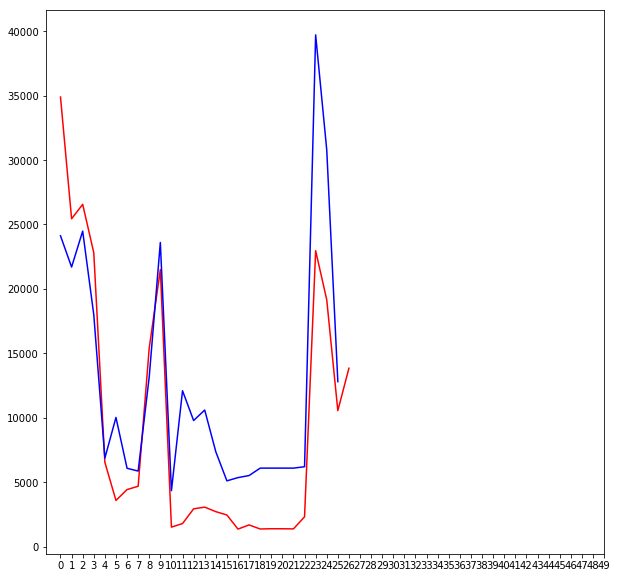


Time Taken :  2.8576345443725586

 {'R2': 0.06107573616904749, 'RMSE': 9644.1124315496891, 'MAE': 7514.2585777777649}

Year :  2015

Month :  Feb
Number of days present :  0

Year :  2015

Month :  Mar
Number of days present :  0

Year :  2015

Month :  Apr
Number of days present :  0

Year :  2015

Month :  May
Number of days present :  0

Year :  2015

Month :  Jun
Number of days present :  0

Year :  2015

Month :  Jul
Number of days present :  0

Year :  2015

Month :  Aug
Number of days present :  0

Year :  2015

Month :  Sept
Number of days present :  0

Year :  2015

Month :  Oct
Number of days present :  31
From the loop :  (744, 8)
End i:  30
Passed the original DataFrame corresponding to the house id : 1632.
                localhour     air1      air2     air3 furnace1 furnace2  \
0  2015-10-01 00:00:00-05  8420.45   5661.58  6985.62  1377.83  822.467   
1  2015-10-02 00:00:00-05  4500.18   347.933  6011.55  1373.43    168.5   
2  2015-10-03 00:00:00-05        0   12.4333 

[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.0s finished





 Dimensions of ndf :  (30, 4)
Shape of ndf after merging :  (30, 6)
   dow  month      t-3      t-2      t-1        t
0  NaN    NaN      NaN      NaN      NaN    25073
1  NaN    NaN      NaN      NaN    25073  13760.4
2  NaN    NaN      NaN    25073  13760.4  5168.98
3  3.0    1.0    25073  13760.4  5168.98  6563.98
4  3.0    1.0  13760.4  5168.98  6563.98  10498.9
(27, 5) (27,)
        dow  month
count  27.0   27.0
mean    3.0    1.0
std     0.0    0.0
min     3.0    1.0
25%     3.0    1.0
50%     3.0    1.0
75%     3.0    1.0
max     3.0    1.0
Split done  (18, 5) (9, 5) (18,) (9,)
Feature ranking according to the ETR : 
1. feature 4 (0.603172)
2. feature 2 (0.227866)
3. feature 3 (0.168962)
4. feature 1 (0.000000)
5. feature 0 (0.000000)


[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.1s finished
/opt/anaconda/lib/python3.6/site-packages/matplotlib/axes/_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


Ranking of the features :  [4 3 2 1 1] 



R2 Score :  -0.819565616951
RMSE :  6212.80412348
MAE :  5463.79443704


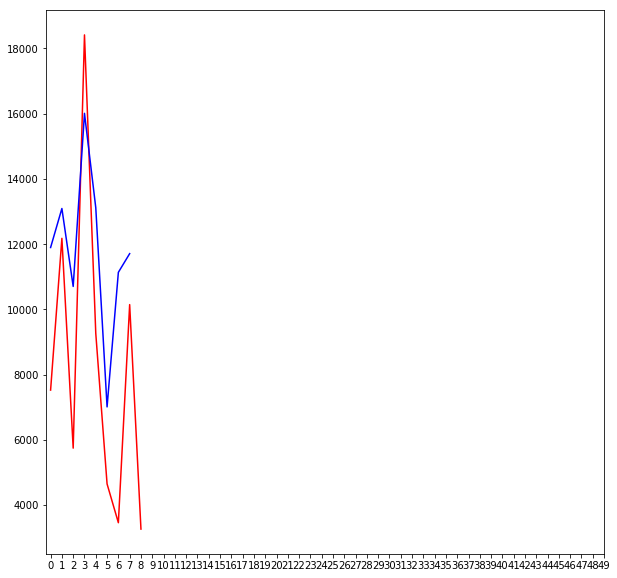


Time Taken :  2.7276968955993652

 {'R2': -0.81956561695100327, 'RMSE': 6212.8041234848442, 'MAE': 5463.7944370370406}

Year :  2015

Month :  Nov
Number of days present :  30
From the loop :  (721, 8)
End i:  30
Passed the original DataFrame corresponding to the house id : 1632.
                localhour     air1     air2     air3 furnace1 furnace2  \
0  2015-11-01 00:00:00-05        0      0.5  3.71667  123.133  120.033   
1  2015-11-01 23:00:00-06      0.1     1.15  5.56667  122.833  120.067   
2  2015-11-02 23:00:00-06     0.15  2.33333  1189.98  364.067   119.85   
3  2015-11-03 23:00:00-06      0.2  1.08333  3.81667  126.817  120.233   
4  2015-11-04 23:00:00-06  2459.43  1.33333  3458.92    786.9    158.6   

  waterheater1 total_thermal_load  
0      2281.35            2528.73  
1      3584.72            3834.43  
2      2680.37            4356.75  
3       2618.3            2870.45  
4         3021            9886.18  
(30, 8)
Inside extra trees :  (30, 8)
mean : 11675.117777

[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.0s finished


Feature ranking according to the ETR : 
1. feature 4 (0.390423)
2. feature 2 (0.319301)
3. feature 3 (0.290277)
4. feature 1 (0.000000)
5. feature 0 (0.000000)


[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.1s finished
/opt/anaconda/lib/python3.6/site-packages/matplotlib/axes/_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


Ranking of the features :  [4 3 1 2 1] 



R2 Score :  -0.855324091117
RMSE :  25494.460416
MAE :  19184.7722667


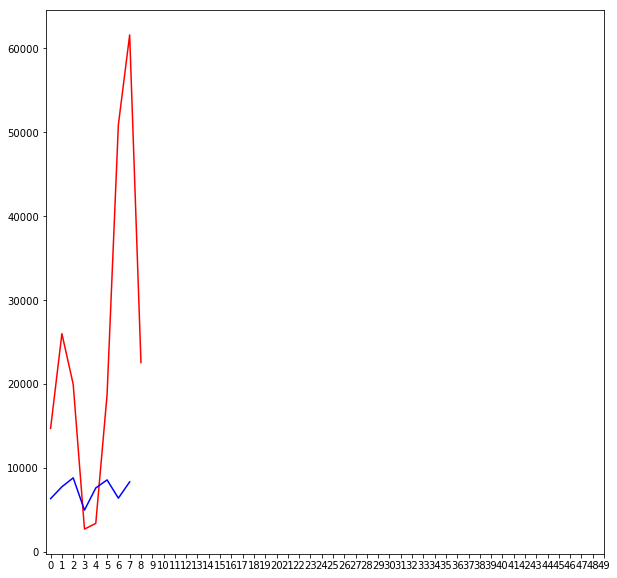


Time Taken :  2.8115932941436768

 {'R2': -0.85532409111678143, 'RMSE': 25494.460415960551, 'MAE': 19184.77226666667}

Year :  2015

Month :  Dec
Number of days present :  31
From the loop :  (744, 8)
End i:  30
Passed the original DataFrame corresponding to the house id : 1632.
                localhour  air1     air2     air3 furnace1 furnace2  \
0  2015-12-01 00:00:00-06   0.3  23.1167  7.31667  29806.6  1065.98   
1  2015-12-02 00:00:00-06  0.95     16.2     5.75  17846.9   874.45   
2  2015-12-03 00:00:00-06   0.3    14.45  8.06667  17980.5  1692.07   
3  2015-12-04 00:00:00-06   0.2  17.4167  5.41667  21984.9  1618.07   
4  2015-12-05 00:00:00-06   0.2  21.8167      4.7  29337.2  1620.57   

  waterheater1 total_thermal_load  
0      3701.85            34605.1  
1       3650.2            22394.4  
2      4261.63              23957  
3      3066.93              26693  
4      2553.37            33537.9  
(30, 8)
Inside extra trees :  (30, 8)
mean : 11657.5905556 max: 34605.116666

[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.0s finished


1383.9166666666665
Dimensions of temp :  (30, 2)


 Dimensions of ndf :  (30, 4)
Shape of ndf after merging :  (30, 6)
   dow  month      t-3      t-2      t-1        t
0  NaN    NaN      NaN      NaN      NaN  34605.1
1  NaN    NaN      NaN      NaN  34605.1  22394.4
2  NaN    NaN      NaN  34605.1  22394.4    23957
3  3.0    1.0  34605.1  22394.4    23957    26693
4  3.0    1.0  22394.4    23957    26693  33537.9
(27, 5) (27,)
        dow  month
count  27.0   27.0
mean    3.0    1.0
std     0.0    0.0
min     3.0    1.0
25%     3.0    1.0
50%     3.0    1.0
75%     3.0    1.0
max     3.0    1.0
Split done  (18, 5) (9, 5) (18,) (9,)
Feature ranking according to the ETR : 
1. feature 4 (0.710639)
2. feature 3 (0.151761)
3. feature 2 (0.137600)
4. feature 1 (0.000000)
5. feature 0 (0.000000)


[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.1s finished
/opt/anaconda/lib/python3.6/site-packages/matplotlib/axes/_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


Ranking of the features :  [4 3 2 1 1] 



R2 Score :  0.240713552184
RMSE :  6998.29697104
MAE :  3304.50007778


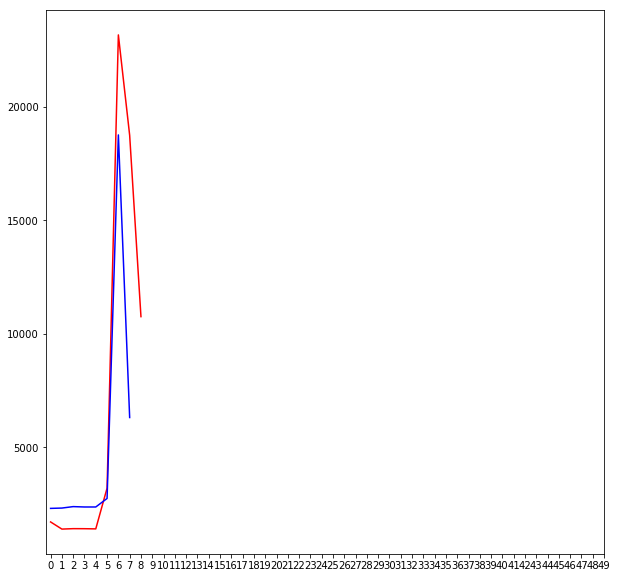


Time Taken :  2.739487886428833

 {'R2': 0.24071355218371138, 'RMSE': 6998.2969710438347, 'MAE': 3304.5000777777732}

Year :  2016

Month :  Jan
Number of days present :  92
From the loop :  (2209, 8)
End i:  92
Passed the original DataFrame corresponding to the house id : 1632.
                localhour     air1      air2     air3 furnace1 furnace2  \
0  2016-10-01 00:00:00-05     0.15   1.31667      1.2   120.35   120.25   
1  2016-10-02 00:00:00-05      0.2  0.616667  522.683  236.883  120.067   
2  2016-10-03 00:00:00-05  1123.47      0.45  1343.58  414.533  119.333   
3  2016-10-04 00:00:00-05  7264.27       0.2  2428.83  626.917  116.717   
4  2016-10-05 00:00:00-05    11771   2875.27  4051.13  940.167  501.217   

  waterheater1 total_thermal_load  
0      824.317            1067.58  
1      807.633            1688.08  
2       1256.2            4257.57  
3        415.3            10852.2  
4      861.017            20999.8  
(92, 8)
Inside extra trees :  (92, 8)
mean : 7185.09

[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.0s finished


 (92, 4)
Shape of ndf after merging :  (92, 6)
   dow  month      t-3      t-2      t-1        t
0  NaN    NaN      NaN      NaN      NaN  1067.58
1  NaN    NaN      NaN      NaN  1067.58  1688.08
2  NaN    NaN      NaN  1067.58  1688.08  4257.57
3  3.0    1.0  1067.58  1688.08  4257.57  10852.2
4  3.0    1.0  1688.08  4257.57  10852.2  20999.8
(89, 5) (89,)
        dow  month
count  89.0   89.0
mean    3.0    1.0
std     0.0    0.0
min     3.0    1.0
25%     3.0    1.0
50%     3.0    1.0
75%     3.0    1.0
max     3.0    1.0
Split done  (62, 5) (27, 5) (62,) (27,)
Feature ranking according to the ETR : 
1. feature 4 (0.662064)
2. feature 3 (0.205314)
3. feature 2 (0.132622)
4. feature 1 (0.000000)
5. feature 0 (0.000000)


[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.1s finished
/opt/anaconda/lib/python3.6/site-packages/matplotlib/axes/_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


Ranking of the features :  [4 3 1 2 1] 



R2 Score :  0.171216930728
RMSE :  10087.721166
MAE :  6486.22987901


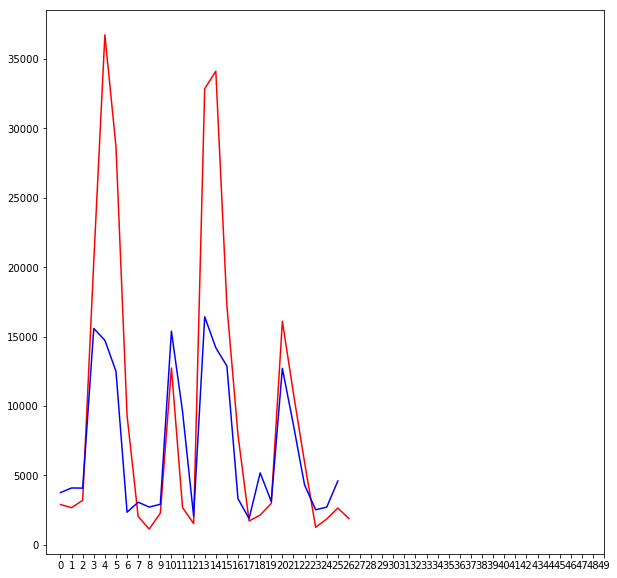


Time Taken :  2.886345863342285

 {'R2': 0.17121693072772015, 'RMSE': 10087.721166040461, 'MAE': 6486.2298790123486}

Year :  2016

Month :  Feb
Number of days present :  0

Year :  2016

Month :  Mar
Number of days present :  0

Year :  2016

Month :  Apr
Number of days present :  0

Year :  2016

Month :  May
Number of days present :  0

Year :  2016

Month :  Jun
Number of days present :  0

Year :  2016

Month :  Jul
Number of days present :  0

Year :  2016

Month :  Aug
Number of days present :  0

Year :  2016

Month :  Sept
Number of days present :  0

Year :  2016

Month :  Oct
Number of days present :  31
From the loop :  (744, 8)
End i:  30
Passed the original DataFrame corresponding to the house id : 1632.
                localhour     air1      air2     air3 furnace1 furnace2  \
0  2016-10-01 00:00:00-05     0.15   1.31667      1.2   120.35   120.25   
1  2016-10-02 00:00:00-05      0.2  0.616667  522.683  236.883  120.067   
2  2016-10-03 00:00:00-05  1123.47      0.45  

[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.0s finished


Dimensions of temp :  (30, 2)


 Dimensions of ndf :  (30, 4)
Shape of ndf after merging :  (30, 6)
   dow  month      t-3      t-2      t-1        t
0  NaN    NaN      NaN      NaN      NaN  1067.58
1  NaN    NaN      NaN      NaN  1067.58  1688.08
2  NaN    NaN      NaN  1067.58  1688.08  4257.57
3  3.0    1.0  1067.58  1688.08  4257.57  10852.2
4  3.0    1.0  1688.08  4257.57  10852.2  20999.8
(27, 5) (27,)
        dow  month
count  27.0   27.0
mean    3.0    1.0
std     0.0    0.0
min     3.0    1.0
25%     3.0    1.0
50%     3.0    1.0
75%     3.0    1.0
max     3.0    1.0
Split done  (18, 5) (9, 5) (18,) (9,)
Feature ranking according to the ETR : 
1. feature 4 (0.517582)
2. feature 2 (0.245909)
3. feature 3 (0.236508)
4. feature 1 (0.000000)
5. feature 0 (0.000000)


[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.1s finished
/opt/anaconda/lib/python3.6/site-packages/matplotlib/axes/_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


Ranking of the features :  [4 3 1 2 1] 



R2 Score :  0.21796068504
RMSE :  5271.19069368
MAE :  4422.18735556


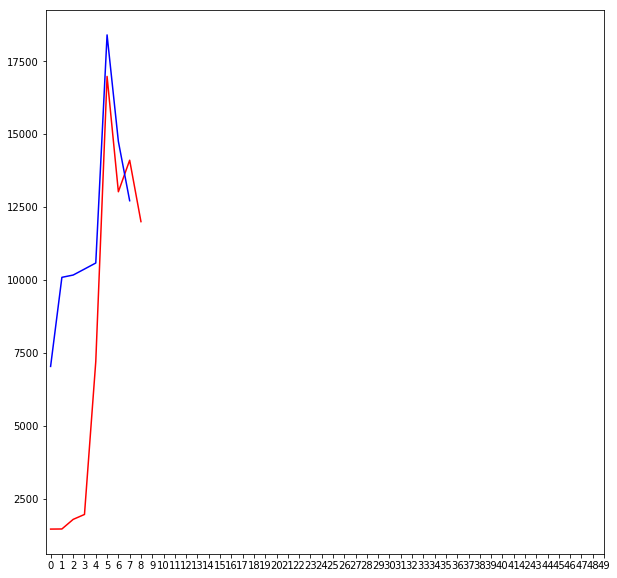


Time Taken :  2.74501633644104

 {'R2': 0.21796068504021937, 'RMSE': 5271.1906936773084, 'MAE': 4422.1873555555649}

Year :  2016

Month :  Nov
Number of days present :  30
From the loop :  (721, 8)
End i:  30
Passed the original DataFrame corresponding to the house id : 1632.
                localhour     air1      air2     air3 furnace1 furnace2  \
0  2016-11-01 00:00:00-05  7912.02   2176.38  2332.62   606.85    405.3   
1  2016-11-02 00:00:00-05  6588.82   394.383   1421.5  434.317  172.833   
2  2016-11-03 00:00:00-05  2481.33   128.667      0.6   119.85  140.683   
3  2016-11-04 00:00:00-05     0.05  0.716667        2   126.75  119.967   
4  2016-11-05 00:00:00-05        0  0.733333      1.9  125.867      120   

  waterheater1 total_thermal_load  
0      835.567            14268.7  
1      821.167            9833.02  
2      830.183            3701.32  
3      1230.18            1479.67  
4       1205.1             1453.6  
(30, 8)
Inside extra trees :  (30, 8)
mean : 3403.9538

[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.0s finished


 14268.733333333334 min: 1399.5333333333328
Dimensions of temp :  (30, 2)


 Dimensions of ndf :  (30, 4)
Shape of ndf after merging :  (30, 6)
   dow  month      t-3      t-2      t-1        t
0  NaN    NaN      NaN      NaN      NaN  14268.7
1  NaN    NaN      NaN      NaN  14268.7  9833.02
2  NaN    NaN      NaN  14268.7  9833.02  3701.32
3  3.0    1.0  14268.7  9833.02  3701.32  1479.67
4  3.0    1.0  9833.02  3701.32  1479.67   1453.6
(27, 5) (27,)
        dow  month
count  27.0   27.0
mean    3.0    1.0
std     0.0    0.0
min     3.0    1.0
25%     3.0    1.0
50%     3.0    1.0
75%     3.0    1.0
max     3.0    1.0
Split done  (18, 5) (9, 5) (18,) (9,)
Feature ranking according to the ETR : 
1. feature 3 (0.514488)
2. feature 2 (0.284836)
3. feature 4 (0.200676)
4. feature 1 (0.000000)
5. feature 0 (0.000000)


[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.1s finished
/opt/anaconda/lib/python3.6/site-packages/matplotlib/axes/_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


Ranking of the features :  [4 3 2 1 1] 



R2 Score :  -0.345396848741
RMSE :  1569.06405908
MAE :  1349.93976296


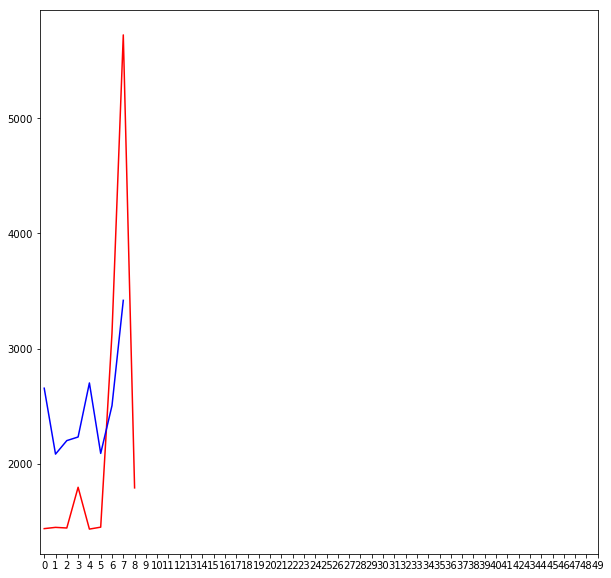


Time Taken :  2.817448854446411

 {'R2': -0.34539684874118448, 'RMSE': 1569.0640590805078, 'MAE': 1349.9397629629659}

Year :  2016

Month :  Dec
Number of days present :  31
From the loop :  (744, 8)
End i:  30
Passed the original DataFrame corresponding to the house id : 1632.
                localhour      air1      air2     air3 furnace1 furnace2  \
0  2016-12-01 00:00:00-06  0.366667  0.833333     2.25    120.5  1056.57   
1  2016-12-02 00:00:00-06       0.3      2.15      1.8  120.383   868.45   
2  2016-12-03 00:00:00-06      0.95   4.08333     2.25   120.35  1076.93   
3  2016-12-04 00:00:00-06         0      0.35      2.3   120.45  1298.05   
4  2016-12-05 00:00:00-06   1.46667       2.8  2.21667  120.083  1201.48   

  waterheater1 total_thermal_load  
0      1588.45            2768.97  
1      1200.17            2193.25  
2      1603.17            2807.73  
3      1591.07            3012.22  
4      1570.03            2898.08  
(30, 8)
Inside extra trees :  (30, 8)
mean : 9

[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.0s finished


 (30, 2)


 Dimensions of ndf :  (30, 4)
Shape of ndf after merging :  (30, 6)
   dow  month      t-3      t-2      t-1        t
0  NaN    NaN      NaN      NaN      NaN  2768.97
1  NaN    NaN      NaN      NaN  2768.97  2193.25
2  NaN    NaN      NaN  2768.97  2193.25  2807.73
3  3.0    1.0  2768.97  2193.25  2807.73  3012.22
4  3.0    1.0  2193.25  2807.73  3012.22  2898.08
(27, 5) (27,)
        dow  month
count  27.0   27.0
mean    3.0    1.0
std     0.0    0.0
min     3.0    1.0
25%     3.0    1.0
50%     3.0    1.0
75%     3.0    1.0
max     3.0    1.0
Split done  (18, 5) (9, 5) (18,) (9,)
Feature ranking according to the ETR : 
1. feature 4 (0.480552)
2. feature 2 (0.295028)
3. feature 3 (0.224420)
4. feature 1 (0.000000)
5. feature 0 (0.000000)


[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.1s finished
/opt/anaconda/lib/python3.6/site-packages/matplotlib/axes/_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


Ranking of the features :  [4 3 1 2 1] 



R2 Score :  -2.48774877682
RMSE :  9044.4308992
MAE :  7927.11833333


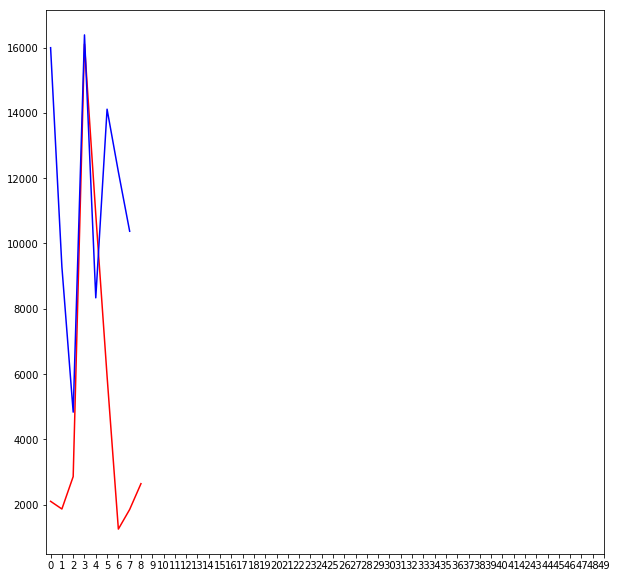


Time Taken :  2.7129197120666504

 {'R2': -2.4877487768193793, 'RMSE': 9044.4308992042279, 'MAE': 7927.1183333333483}

Year :  2017

Month :  Jan
Number of days present :  47
From the loop :  (1156, 8)
End i:  48
Passed the original DataFrame corresponding to the house id : 1632.
                localhour     air1     air2     air3 furnace1 furnace2  \
0  2017-10-01 00:00:00-05  3977.37  1485.52  1627.15  456.483   334.15   
1  2017-10-02 00:00:00-05   7745.9  2380.33  2040.43  541.567  426.867   
2  2017-10-03 00:00:00-05   6802.5  291.533   551.35  238.367  161.517   
3  2017-10-04 00:00:00-05  7775.02  1994.43   2810.3  701.017   390.55   
4  2017-10-05 00:00:00-05  8339.45  1594.73  2858.82    712.9  337.783   

  waterheater1 total_thermal_load  
0      837.817            8718.48  
1      843.533            13978.6  
2       843.65            8888.92  
3      841.883            14513.2  
4      842.333              14686  
(48, 8)
Inside extra trees :  (48, 8)
mean : 4863.2864583

[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.0s finished


Feature ranking according to the ETR : 
1. feature 4 (0.609005)
2. feature 3 (0.219420)
3. feature 2 (0.171575)
4. feature 1 (0.000000)
5. feature 0 (0.000000)


[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.1s finished
/opt/anaconda/lib/python3.6/site-packages/matplotlib/axes/_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


Ranking of the features :  [4 3 1 2 1] 



R2 Score :  -0.903710785235
RMSE :  3294.8254964
MAE :  2347.1126381


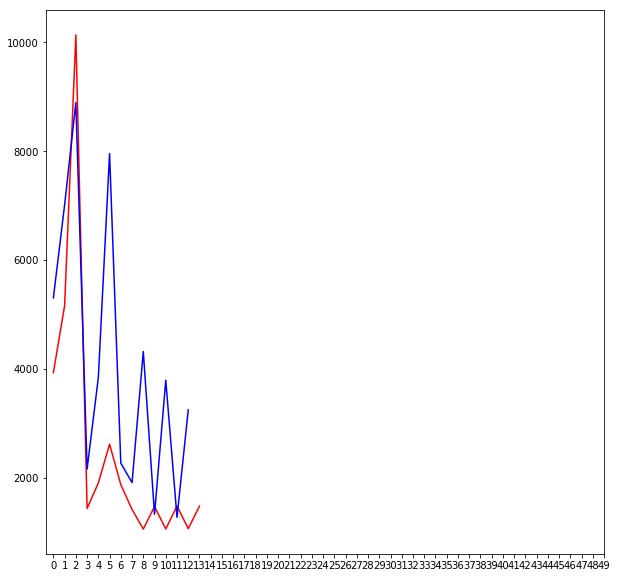


Time Taken :  2.7785868644714355

 {'R2': -0.90371078523533055, 'RMSE': 3294.8254963988097, 'MAE': 2347.112638095236}

Year :  2017

Month :  Feb
Number of days present :  0

Year :  2017

Month :  Mar
Number of days present :  0

Year :  2017

Month :  Apr
Number of days present :  0

Year :  2017

Month :  May
Number of days present :  0

Year :  2017

Month :  Jun
Number of days present :  0

Year :  2017

Month :  Jul
Number of days present :  0

Year :  2017

Month :  Aug
Number of days present :  0

Year :  2017

Month :  Sept
Number of days present :  0

Year :  2017

Month :  Oct
Number of days present :  31
From the loop :  (744, 8)
End i:  30
Passed the original DataFrame corresponding to the house id : 1632.
                localhour     air1     air2     air3 furnace1 furnace2  \
0  2017-10-01 00:00:00-05  3977.37  1485.52  1627.15  456.483   334.15   
1  2017-10-02 00:00:00-05   7745.9  2380.33  2040.43  541.567  426.867   
2  2017-10-03 00:00:00-05   6802.5  291.533   55

[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.0s finished





 Dimensions of ndf :  (30, 4)
Shape of ndf after merging :  (30, 6)
   dow  month      t-3      t-2      t-1        t
0  NaN    NaN      NaN      NaN      NaN  8718.48
1  NaN    NaN      NaN      NaN  8718.48  13978.6
2  NaN    NaN      NaN  8718.48  13978.6  8888.92
3  3.0    1.0  8718.48  13978.6  8888.92  14513.2
4  3.0    1.0  13978.6  8888.92  14513.2    14686
(27, 5) (27,)
        dow  month
count  27.0   27.0
mean    3.0    1.0
std     0.0    0.0
min     3.0    1.0
25%     3.0    1.0
50%     3.0    1.0
75%     3.0    1.0
max     3.0    1.0
Split done  (18, 5) (9, 5) (18,) (9,)
Feature ranking according to the ETR : 
1. feature 4 (0.614051)
2. feature 3 (0.246122)
3. feature 2 (0.139827)
4. feature 1 (0.000000)
5. feature 0 (0.000000)


[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.1s finished
/opt/anaconda/lib/python3.6/site-packages/matplotlib/axes/_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


Ranking of the features :  [4 3 2 1 1] 



R2 Score :  -35.4455623503
RMSE :  4950.19952214
MAE :  3373.08364815


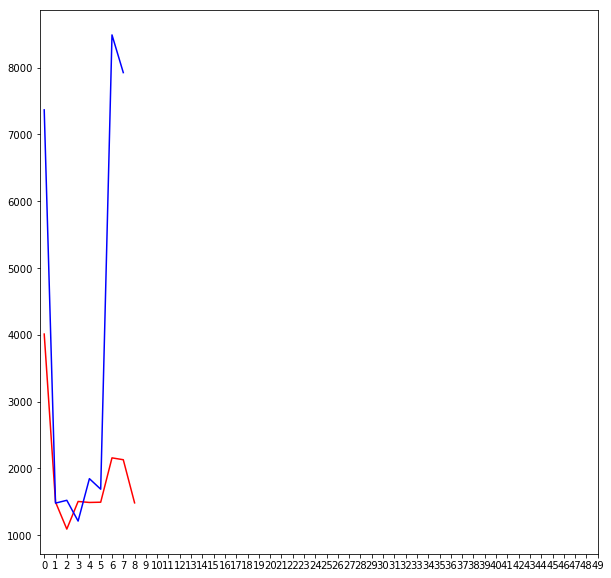


Time Taken :  2.7280936241149902

 {'R2': -35.445562350308116, 'RMSE': 4950.1995221428415, 'MAE': 3373.0836481481351}

Year :  2017

Month :  Nov
Number of days present :  16

Year :  2017

Month :  Dec
Number of days present :  0


In [188]:
'''
Checking how many days are present in each day of the month, for the entire dataset.
'''
year = [2013,2014,2015,2016,2017]
month = ["1","2","3","4","5","6","7","8","9","10","11","12"]
month_days = ["Jan","Feb","Mar","Apr","May","Jun","Jul","Aug","Sept","Oct","Nov","Dec"]

for y in year:
    for m in month:
        print("\nYear : ",y)
        print("\nMonth : ",month_days[int(m)-1])
        num_hours = np.sum(df_new_thermal["localhour"].str.contains(str(y)+"-"+m))
        num_days = np.sum(new_df1["localhour"].str.contains(str(y)+"-"+m))
        print ( "Number of days present : " , num_days )
        
        #Only train a model, if there are sufficient number of days, i.e >= 672 (hours)
        if (num_days >= 28):
            monthdf = pd.DataFrame(df_new_thermal[df_new_thermal["localhour"].str.contains(str(y)+"-"+m)],columns = df_new_thermal.columns)
            print ("From the loop : ",monthdf.shape)
            #Now, pass it to the model.
            thermal_dict = {}
            ti = time.time()
            thermal_dict1,y_test1,y_pred1 = extra_trees(monthdf,thermal_dict,1,"mean_squared_error",7,day_hour)
            tf = time.time()
            print ("\nTime Taken : ",tf-ti)
            print ("\n",thermal_dict1)

End i:  1700
Passed the original DataFrame corresponding to the house id : 1632.
                localhour      air1      air2 air3 furnace1 furnace2  \
0  2013-03-23 08:00:00-05         0         0    0  142.417  502.533   
1  2013-03-24 08:00:00-05         0         0    0  4182.12  2967.85   
2  2013-03-25 08:00:00-05      0.15  0.383333    0  10421.1  3787.13   
3  2013-03-26 08:00:00-05         0         0    0  5657.58   2665.9   
4  2013-03-27 08:00:00-05  0.133333         0    0     3477  1465.53   

  waterheater1 total_thermal_load  
0      2567.92            3212.87  
1      1473.55            8623.52  
2      5991.67            20200.4  
3      1437.45            9760.93  
4      4167.75            9110.42  
(1700, 8)
Inside extra trees :  (1700, 8)
mean : 14106.0630784 max: 73695.08333333334 min: 552.5999999999999
Dimensions of temp :  (1700, 2)


 Dimensions of ndf :  (1700, 31)
Shape of ndf after merging :  (1700, 33)
   dow  month t-30 t-29 t-28 t-27 t-26 t-25 t-24 t-23

[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    3.6s finished
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.1s finished


Feature ranking according to the ETR : 
1. feature 31 (0.481608)
2. feature 30 (0.084985)
3. feature 29 (0.048081)
4. feature 28 (0.047863)
5. feature 27 (0.034585)
6. feature 1 (0.017904)
7. feature 26 (0.016607)
8. feature 19 (0.015672)
9. feature 18 (0.015390)
10. feature 25 (0.013594)
11. feature 24 (0.012973)
12. feature 20 (0.012040)


[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    4.9s finished
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    4.8s finished
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    4.6s finished
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    4.4s finished
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    4.3s finished
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    4.2s finished
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    4.0s finished
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    3.9s finished
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    3.7s finished
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    3.6s finished
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    3.5s finished
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    3.3s finished
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    3.2s finished
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    3.1s finished
[Parallel(n_jobs=1)]

13. feature 23 (0.011777)
14. feature 5 (0.011540)
15. feature 15 (0.011298)
16. feature 17 (0.011265)
17. feature 2 (0.011133)
18. feature 8 (0.010776)
19. feature 0 (0.010515)
20. feature 16 (0.010448)
21. feature 4 (0.010039)
22. feature 21 (0.009846)
23. feature 12 (0.009810)
24. feature 22 (0.009759)
25. feature 14 (0.009473)
26. feature 13 (0.009436)
27. feature 11 (0.009375)
28. feature 6 (0.009149)
29. feature 3 (0.008808)
30. feature 9 (0.008719)
31. feature 7 (0.008158)
32. feature 10 (0.007372)
Ranking of the features :  [11  1  6 14  3  1 12 16  7 15 17  4  9  1 13  1 10  1  1  1  1  8  2  1  5
  1  1  1  1  1  1  1] 



R2 Score :  0.683907545756
RMSE :  6606.91884301
MAE :  4630.7382815


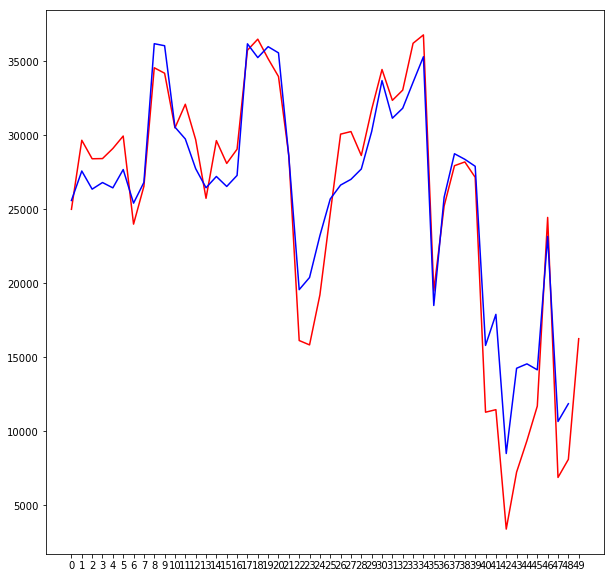


Time Taken :  75.69779753684998

 {'R2': 0.68390754575607671, 'RMSE': 6606.9188430053027, 'MAE': 4630.7382815036599}


In [142]:
'''
Running the extra trees regressor on df_new_thermal, where :
df_new_thermal : full dataframe of house:1632 with consumption in Watt-Hr.
'''
thermal_dict = {}
model_history = {}
ti = time.time()
thermal_dict1,y_test1,y_pred1 = extra_trees(df_new_thermal,thermal_dict,1,"mean_squared_error",7,day_hour,stop=30)
tf = time.time()
print ("\nTime Taken : ",tf-ti)
print ("\n",thermal_dict1)

In [27]:
df_thermal.head()

,localhour,air1,air2,air3,furnace1,furnace2,waterheater1,total_thermal_load
0,2013-03-23 08:00:00-05,0,0,0,0.0059,0.01,0,0.0159
1,2013-03-23 09:00:00-05,0,0,0,0.00491667,0.01,0,0.0149167
2,2013-03-23 10:00:00-05,0,0,0,0.0059,0.0762833,0.181567,0.26375
3,2013-03-23 11:00:00-05,0,0,0,0.0059,0.0760333,1.32477,1.4067
4,2013-03-23 12:00:00-05,0,0,0,0.006,0.01,0,0.016


End i:  1700
Passed the original DataFrame corresponding to the house id : 1632.
                localhour         air1         air2 air3  furnace1  furnace2  \
0  2013-03-23 08:00:00-05            0            0    0  0.142417  0.502533   
1  2013-03-24 08:00:00-05            0            0    0   4.18212   2.96785   
2  2013-03-25 08:00:00-05      0.00015  0.000383333    0   10.4211   3.78713   
3  2013-03-26 08:00:00-05            0            0    0   5.65758    2.6659   
4  2013-03-27 08:00:00-05  0.000133333            0    0     3.477   1.46553   

  waterheater1 total_thermal_load  
0      2.56792            3.21287  
1      1.47355            8.62352  
2      5.99167            20.2004  
3      1.43745            9.76093  
4      4.16775            9.11042  
(1700, 8)
Inside extra trees :  (1700, 8)
mean : 14.1060630784 max: 73.69508333333333 min: 0.5525999999999999

 The DataFrame to be passed to the model. 
          0
0  3.21287
1  8.62352
2  20.2004
3  9.76093
4  9.11042
(

[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    1.1s finished
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.1s finished
/opt/anaconda/lib/python3.6/site-packages/matplotlib/axes/_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


R2 Score :  0.652360226906
MSE :  12.2927772293
MAE :  2.56187214645


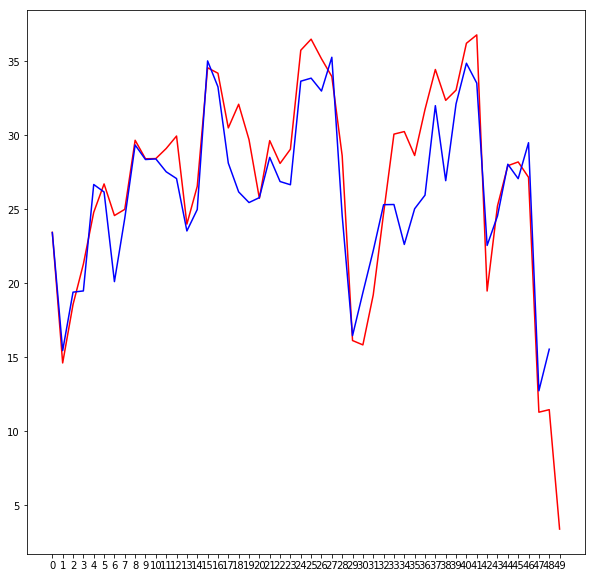

Time Taken :  2.2321622371673584
{'R2': 0.65236022690642315, 'MSE': 12.292777229332618, 'MAE': 2.5618721464497018}


In [28]:
'''
Running extra-trees regressor on df_thermal, where :
df_thermal : full dataframe of house:1632 with the consumptions in KWhr.
'''
thermal_dict1 = {}
model_history1 = {}
ti = time.time()
thermal_dict1,y_test1,y_pred1 = extra_trees(df_thermal,thermal_dict,1,"mean_squared_error",7,day_hour)
tf = time.time()

print ("Time Taken : ",tf-ti)
print (thermal_dict1)

End i:  1700
Passed the original DataFrame corresponding to the house id : 1632.
                localhour         air1         air2 air3  furnace1  furnace2  \
0  2013-03-23 08:00:00-05            0            0    0  0.142417  0.502533   
1  2013-03-24 08:00:00-05            0            0    0   4.18212   2.96785   
2  2013-03-25 08:00:00-05      0.00015  0.000383333    0   10.4211   3.78713   
3  2013-03-26 08:00:00-05            0            0    0   5.65758    2.6659   
4  2013-03-27 08:00:00-05  0.000133333            0    0     3.477   1.46553   

  waterheater1 total_thermal_load  
0      2.56792            3.21287  
1      1.47355            8.62352  
2      5.99167            20.2004  
3      1.43745            9.76093  
4      4.16775            9.11042  
(1700, 8)
Inside extra trees :  (1700, 8)
mean : 14.1060630784 max: 73.69508333333333 min: 0.5525999999999999

 The DataFrame to be passed to the model. 
          0
0  3.21287
1  8.62352
2  20.2004
3  9.76093
4  9.11042
(

[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    1.0s finished
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.1s finished
/opt/anaconda/lib/python3.6/site-packages/matplotlib/axes/_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


R2 Score :  0.65043674491
MSE :  12.2962747864
MAE :  2.56178771611


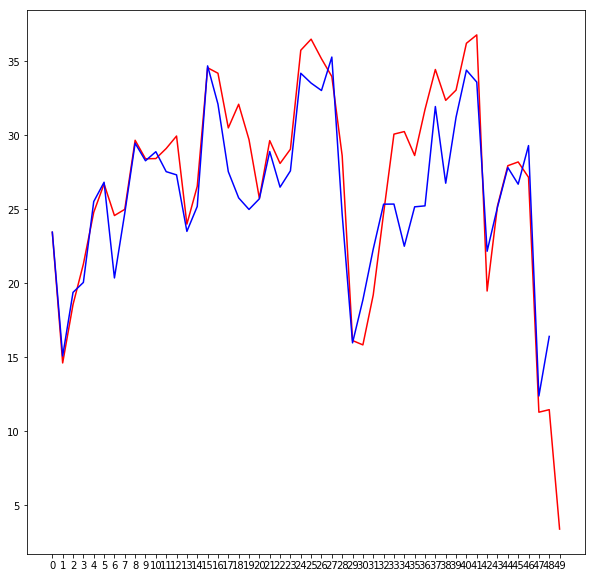

Time Taken :  2.060117244720459
{'R2': 0.65043674490967673, 'MSE': 12.296274786411789, 'MAE': 2.5617877161078226}


In [29]:
'''
Running extra trees regressor considering only 'air1','furnace1' and 'heater1', of house : 1632, 
where the dataframe contains consumption in terms of KWhr.

When run on all the columns,

('R2 Score : ', 0.6522723453798559)
('MSE : ', 12.20056712597718)
('MAE : ', 2.5690554018737646)

'''
thermal_dict1 = {}
model_history1 = {}
ti = time.time()
thermal_dict1,y_test1,y_pred1 = extra_trees(df_thermal,thermal_dict,1,"mean_squared_error",7,day_hour)
tf = time.time()

print ("Time Taken : ",tf-ti)
print (thermal_dict1)



 House :  1037
End i:  450
                                           timestamp air1 furnace1  \
0  2014-02-07 19:00:00-062014-02-07 19:00:00-0620...    0  20428.5   
1  2014-02-08 19:00:00-062014-02-08 19:00:00-0620...    0   7923.2   
2  2014-02-09 19:00:00-062014-02-09 19:00:00-0620...    0  11310.3   
3  2014-02-10 19:00:00-062014-02-10 19:00:00-0620...    0  27065.6   
4  2014-02-11 19:00:00-062014-02-11 19:00:00-0620...    0  21793.3   

  waterheater1 total_load  
0         3045    23473.5  
1      1036.67    8959.87  
2      3513.15    14823.5  
3      1186.97    28252.6  
4       2429.2    24222.5  
(450, 5)
Inside extra trees :  (450, 5)
mean : 9912.59274074 max: 38759.86666666666 min: 595.7166666666666

 The DataFrame to be passed to the model. 
          0
0  23473.5
1  8959.87
2  14823.5
3  28252.6
4  24222.5
(443, 7) (443,)
            t-7      t-6      t-5      t-4      t-3      t-2      t-1        t
count    443.00   444.00   445.00   446.00   447.00   448.00   449.00

[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.0s finished
/opt/anaconda/lib/python3.6/site-packages/matplotlib/axes/_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


R2 Score :  0.441301700943
MSE :  31879923.1364
MAE :  3338.26178662


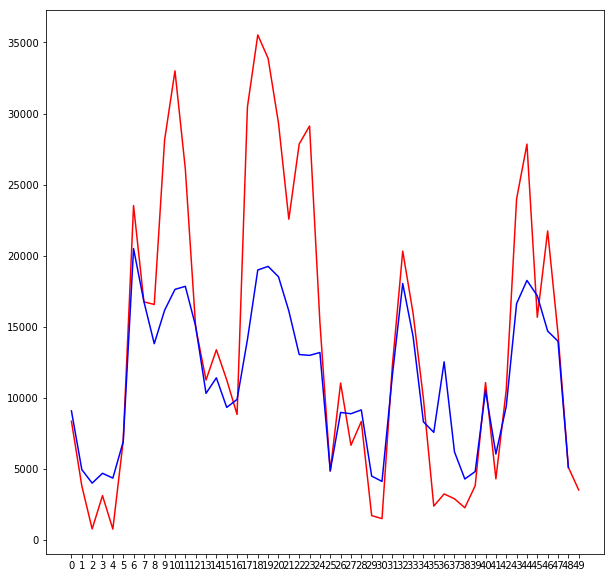

Time Taken :  3.514356851577759
{'R2': 0.44130170094256727, 'MSE': 31879923.136440448, 'MAE': 3338.261786616155}


 House :  115
End i:  1155
                                           timestamp air1 furnace1  \
0  2014-01-24 19:00:00-062014-01-24 19:00:00-0620...    0  19820.9   
1  2014-01-25 19:00:00-062014-01-25 19:00:00-0620...    0  5199.87   
2  2014-01-26 19:00:00-062014-01-26 19:00:00-0620...    0  19829.8   
3  2014-01-27 19:00:00-062014-01-27 19:00:00-0620...    0  39658.6   
4  2014-01-28 19:00:00-062014-01-28 19:00:00-0620...    0  31764.2   

  waterheater1 total_load  
0       1102.5    20923.4  
1      1241.45    6441.32  
2      1227.93    21057.7  
3         1931    41589.6  
4      1681.98    33446.2  
(1155, 5)
Inside extra trees :  (1155, 5)
mean : 7630.87502165 max: 56141.48333333334 min: 363.5833333333332

 The DataFrame to be passed to the model. 
          0
0  20923.4
1  6441.32
2  21057.7
3  41589.6
4  33446.2
(1148, 7) (1148,)
           t-7     t-6     t-5 

[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.8s finished
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.1s finished
/opt/anaconda/lib/python3.6/site-packages/matplotlib/axes/_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


R2 Score :  0.732991711498
MSE :  5303299.34285
MAE :  1771.9387468


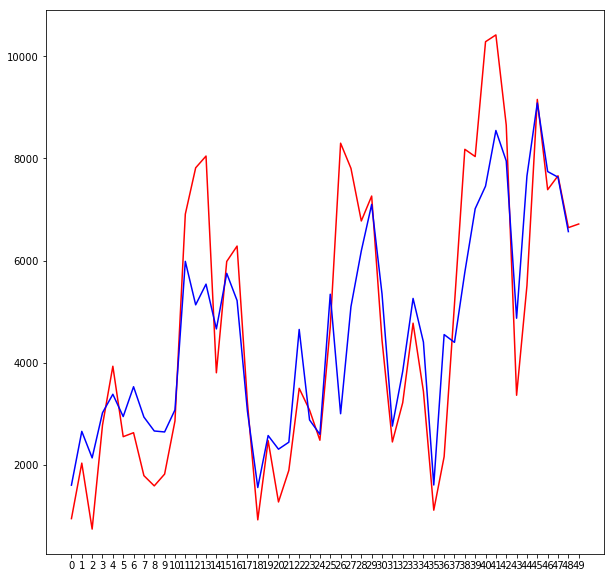

Time Taken :  17.2287757396698
{'R2': 0.73299171149847475, 'MSE': 5303299.3428481333, 'MAE': 1771.9387468023226}


 House :  2401
End i:  1231
                                           timestamp air1 furnace1  \
0  2014-01-04 19:00:00-062014-01-04 19:00:00-0620...    0    11807   
1  2014-01-05 19:00:00-062014-01-05 19:00:00-0620...    0  50385.7   
2  2014-01-06 19:00:00-062014-01-06 19:00:00-0620...    0    25804   
3  2014-01-07 19:00:00-062014-01-07 19:00:00-0620...    0  11727.4   
4  2014-01-08 19:00:00-062014-01-08 19:00:00-0620...    0  3327.92   

  waterheater1 total_load  
0         4309      16116  
1      2906.05    53291.7  
2      1604.37    27408.3  
3      2407.25    14134.7  
4      2433.78     5761.7  
(1231, 5)
Inside extra trees :  (1231, 5)
mean : 9222.48122123 max: 53291.73333333333 min: 422.79999999999995

 The DataFrame to be passed to the model. 
          0
0    16116
1  53291.7
2  27408.3
3  14134.7
4   5761.7
(1224, 7) (1224,)
                t-7          

[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.8s finished
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.1s finished
/opt/anaconda/lib/python3.6/site-packages/matplotlib/axes/_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


R2 Score :  0.499137376772
MSE :  13281373.7595
MAE :  2541.76692543


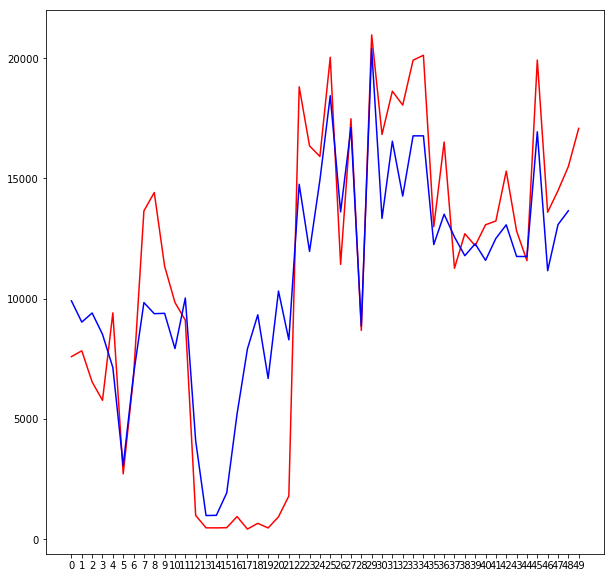

Time Taken :  19.03609013557434
{'R2': 0.49913737677160441, 'MSE': 13281373.75949093, 'MAE': 2541.7669254314333}


 House :  3268
End i:  1083
                                           timestamp      air1 furnace1  \
0  2014-01-29 19:00:00-062014-01-29 19:00:00-0620...   1.08333  31901.1   
1  2014-01-30 19:00:00-062014-01-30 19:00:00-0620...  0.983333  2331.65   
2  2014-01-31 19:00:00-062014-01-31 19:00:00-0620...       0.7        0   
3  2014-02-01 19:00:00-062014-02-01 19:00:00-0620...   1.06667  11474.7   
4  2014-02-02 19:00:00-062014-02-02 19:00:00-0620...   5.08333  18486.8   

  waterheater1 total_load  
0      740.283    32642.5  
1      738.483    3071.12  
2      523.233    523.933  
3      725.517    12201.3  
4      3130.28    21622.1  
(1083, 5)
Inside extra trees :  (1083, 5)
mean : 4589.67005809 max: 44031.3 min: 364.99999999999983

 The DataFrame to be passed to the model. 
          0
0  32642.5
1  3071.12
2  523.933
3  12201.3
4  21622.1
(1076, 7) (1076,)
         

[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.6s finished
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.0s finished
/opt/anaconda/lib/python3.6/site-packages/matplotlib/axes/_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


R2 Score :  0.369064406449
MSE :  4525845.47938
MAE :  1116.5819131


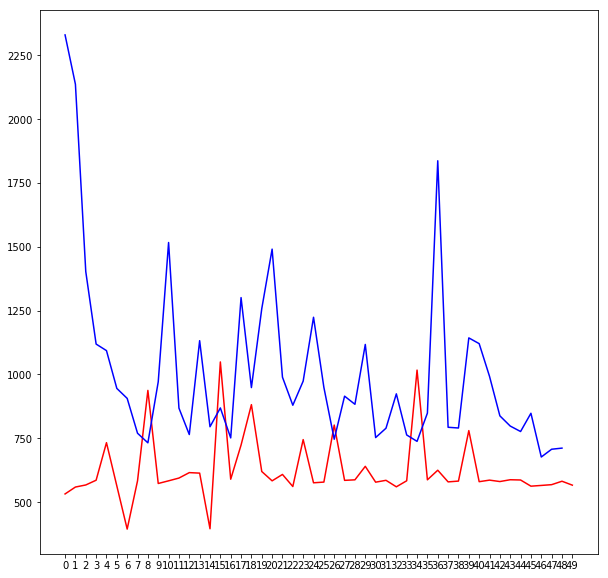

Time Taken :  14.456186532974243
{'R2': 0.36906440644887395, 'MSE': 4525845.4793827049, 'MAE': 1116.5819130952382}


 House :  3273
End i:  1385
                                           timestamp  air1 furnace1  \
0  2013-12-17 19:00:00-062013-12-17 19:00:00-0620...  0.55     2.95   
1  2013-12-18 19:00:00-062013-12-18 19:00:00-0620...     0      2.4   
2  2013-12-19 19:00:00-062013-12-19 19:00:00-0620...     0        0   
3  2013-12-20 19:00:00-062013-12-20 19:00:00-0620...     0  3.48333   
4  2013-12-21 19:00:00-062013-12-21 19:00:00-0620...     0     2.65   

  waterheater1 total_load  
0      3421.87    3425.37  
1      5774.15    5776.55  
2         1621       1621  
3      8605.05    8608.53  
4      3465.72    3468.37  
(1385, 5)
Inside extra trees :  (1385, 5)
mean : 8374.72022864 max: 35128.58333333333 min: 606.9833333333332

 The DataFrame to be passed to the model. 
          0
0  3425.37
1  5776.55
2     1621
3  8608.53
4  3468.37
(1378, 7) (1378,)
           t-7     t-6

[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.8s finished
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.1s finished


R2 Score :  0.351233494391
MSE :  3564972.98926
MAE : 

/opt/anaconda/lib/python3.6/site-packages/matplotlib/axes/_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


 1467.39726675


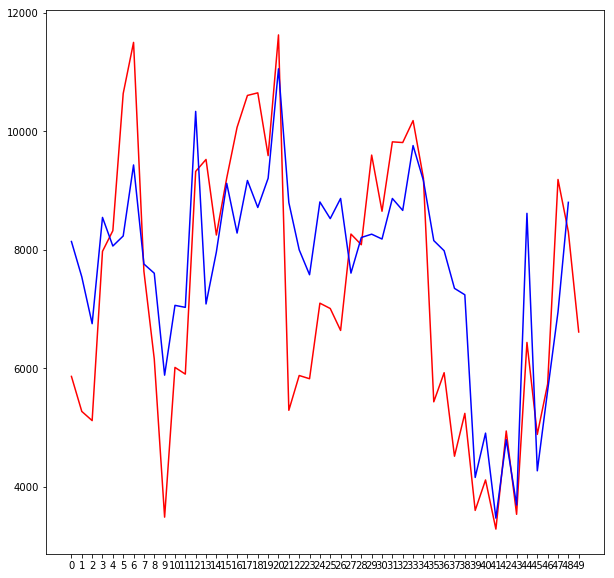

Time Taken :  21.957313537597656
{'R2': 0.35123349439148066, 'MSE': 3564972.9892617967, 'MAE': 1467.397266747377}


 House :  4000
End i:  305
                                           timestamp     air1 furnace1  \
0  2014-01-29 19:00:00-062014-01-29 19:00:00-0620...      6.6  13293.8   
1  2014-01-30 19:00:00-062014-01-30 19:00:00-0620...    12.05  2454.37   
2  2014-01-31 19:00:00-062014-01-31 19:00:00-0620...  12.2667        0   
3  2014-02-01 19:00:00-062014-02-01 19:00:00-0620...     7.15  4171.87   
4  2014-02-02 19:00:00-062014-02-02 19:00:00-0620...  12.5167  14696.3   

  waterheater1 total_load  
0      3747.68    17048.1  
1      6504.68     8971.1  
2       6800.6    6812.87  
3      4112.43    8291.45  
4      6781.08    21489.9  
(305, 5)
Inside extra trees :  (305, 5)
mean : 6330.40295082 max: 31007.833333333336 min: 680.6

 The DataFrame to be passed to the model. 
          0
0  17048.1
1   8971.1
2  6812.87
3  8291.45
4  21489.9
(298, 7) (298,)
            t-7      

[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.0s finished
/opt/anaconda/lib/python3.6/site-packages/matplotlib/axes/_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


R2 Score :  -0.313499808745
MSE :  7269827.13029
MAE :  1907.97310749


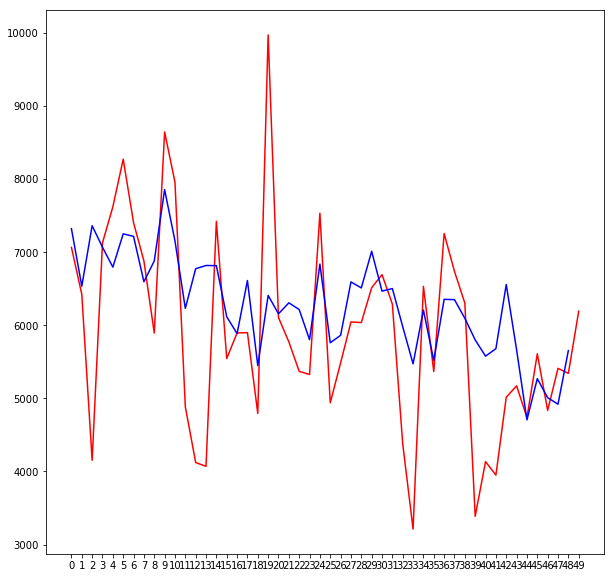

Time Taken :  2.1713335514068604
{'R2': -0.31349980874507644, 'MSE': 7269827.1302890899, 'MAE': 1907.9731074906349}


 House :  6324
End i:  202
                                           timestamp     air1 furnace1  \
0  2014-12-01 01:00:00-062014-12-01 01:00:00-0620...  4.93333   5745.3   
1  2014-12-02 01:00:00-062014-12-02 01:00:00-0620...  4.73333  5120.58   
2  2014-12-03 01:00:00-062014-12-03 01:00:00-0620...  6.31667  315.283   
3  2014-12-04 01:00:00-062014-12-04 01:00:00-0620...  1.76667     0.35   
4  2014-12-05 01:00:00-062014-12-05 01:00:00-0620...  6.26667        0   

  waterheater1 total_load  
0      2848.73    8598.97  
1      2649.65    7774.97  
2      3462.27    3783.87  
3      1019.75    1021.87  
4      3698.32    3704.58  
(202, 5)
Inside extra trees :  (202, 5)
mean : 4028.92211221 max: 20783.283333333333 min: 471.1666666666667

 The DataFrame to be passed to the model. 
          0
0  8598.97
1  7774.97
2  3783.87
3  1021.87
4  3704.58
(195, 7) (195,)
       

[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.0s finished
/opt/anaconda/lib/python3.6/site-packages/matplotlib/axes/_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


(136,) (59,)
R2 Score :  0.0892068988459
MSE :  702759.013342
MAE :  472.139471264


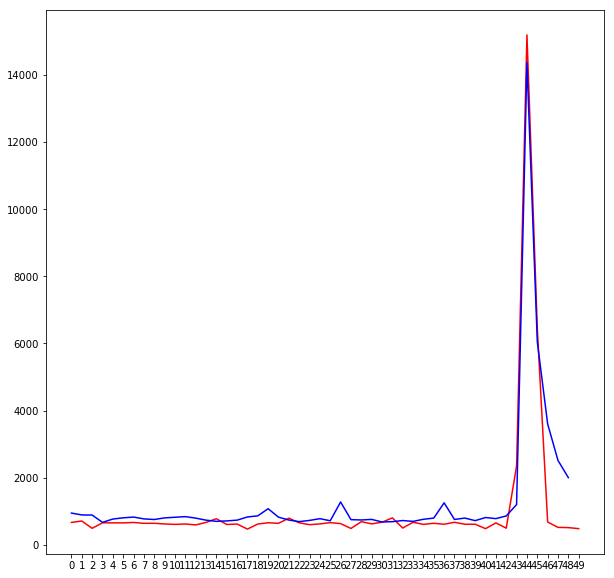

Time Taken :  1.441256046295166
{'R2': 0.089206898845932026, 'MSE': 702759.01334219554, 'MAE': 472.13947126437006}


 House :  6614
End i:  452
                                           timestamp     air1 furnace1  \
0  2013-12-31 19:00:00-062013-12-31 19:00:00-0620...      1.1   2163.2   
1  2014-01-01 19:00:00-062014-01-01 19:00:00-0620...     4.05  9143.13   
2  2014-01-02 19:00:00-062014-01-02 19:00:00-0620...     2.75  7275.53   
3  2014-01-03 19:00:00-062014-01-03 19:00:00-0620...  2.46667  1357.05   
4  2014-01-04 19:00:00-062014-01-04 19:00:00-0620...     2.75  3554.23   

  waterheater1 total_load  
0      1233.62    3397.92  
1      3536.78      12684  
2       2735.6    10013.9  
3      2733.27    4092.78  
4      2073.17    5630.15  
(452, 5)
Inside extra trees :  (452, 5)
mean : 6535.17116519 max: 40480.683333333334 min: 766.5333333333333

 The DataFrame to be passed to the model. 
          0
0  3397.92
1    12684
2  10013.9
3  4092.78
4  5630.15
(445, 7) (445,)
        

[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.0s finished
/opt/anaconda/lib/python3.6/site-packages/matplotlib/axes/_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


R2 Score :  0.106729729152
MSE :  19727426.5571
MAE :  3150.28019799


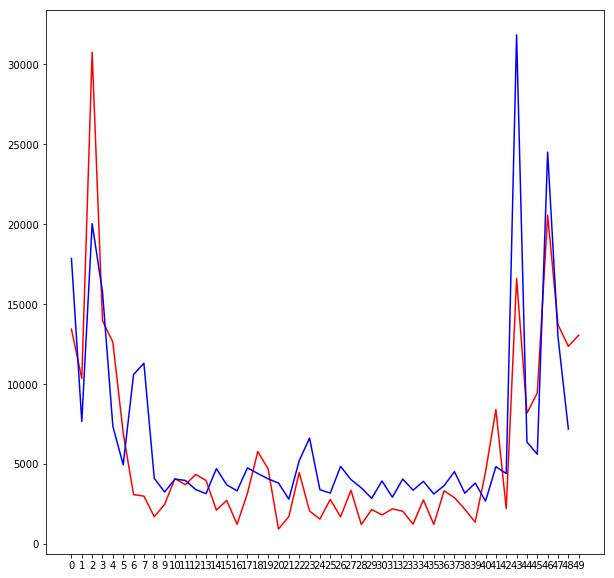

Time Taken :  3.2056527137756348
{'R2': 0.10672972915173495, 'MSE': 19727426.557131562, 'MAE': 3150.2801979949872}


 House :  9912
End i:  1286
                                           timestamp     air1 furnace1  \
0  2013-12-31 19:00:00-062013-12-31 19:00:00-0620...      1.5  12388.8   
1  2014-01-01 19:00:00-062014-01-01 19:00:00-0620...     0.95  8235.38   
2  2014-01-02 19:00:00-062014-01-02 19:00:00-0620...  3.13333  11923.3   
3  2014-01-03 19:00:00-062014-01-03 19:00:00-0620...      3.3  6036.62   
4  2014-01-04 19:00:00-062014-01-04 19:00:00-0620...     3.85      402   

  waterheater1 total_load  
0      2183.45    14573.8  
1      1675.95    9912.28  
2       4111.9    16038.4  
3      4647.52    10687.4  
4      5109.57    5515.42  
(1286, 5)
Inside extra trees :  (1286, 5)
mean : 6980.34348108 max: 40758.61666666666 min: 562.2333333333332

 The DataFrame to be passed to the model. 
          0
0  14573.8
1  9912.28
2  16038.4
3  10687.4
4  5515.42
(1279, 7) (1279,)
    

[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.8s finished
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.1s finished
/opt/anaconda/lib/python3.6/site-packages/matplotlib/axes/_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


R2 Score :  0.525771877808
MSE :  9221402.21821
MAE :  2177.46172071


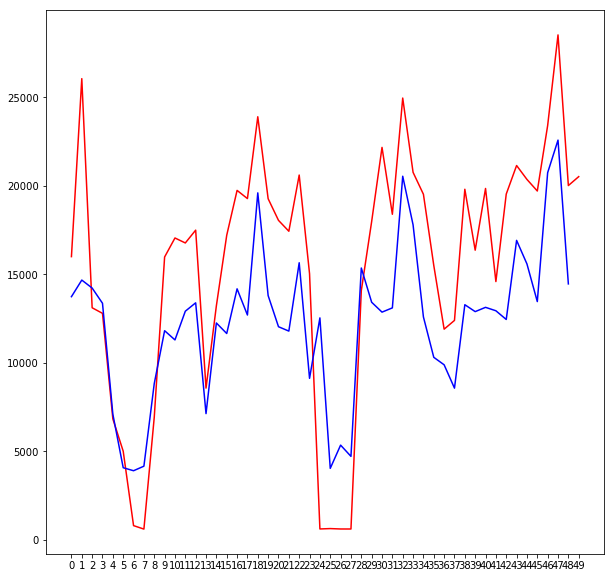

Time Taken :  19.47272777557373
{'R2': 0.52577187780839307, 'MSE': 9221402.2182139251, 'MAE': 2177.4617207136657}
{1037: {'R2': 0.52577187780839307, 'MSE': 9221402.2182139251, 'MAE': 2177.4617207136657}, 115: {'R2': 0.52577187780839307, 'MSE': 9221402.2182139251, 'MAE': 2177.4617207136657}, 2401: {'R2': 0.52577187780839307, 'MSE': 9221402.2182139251, 'MAE': 2177.4617207136657}, 3268: {'R2': 0.52577187780839307, 'MSE': 9221402.2182139251, 'MAE': 2177.4617207136657}, 3273: {'R2': 0.52577187780839307, 'MSE': 9221402.2182139251, 'MAE': 2177.4617207136657}, 4000: {'R2': 0.52577187780839307, 'MSE': 9221402.2182139251, 'MAE': 2177.4617207136657}, 6324: {'R2': 0.52577187780839307, 'MSE': 9221402.2182139251, 'MAE': 2177.4617207136657}, 6614: {'R2': 0.52577187780839307, 'MSE': 9221402.2182139251, 'MAE': 2177.4617207136657}, 9912: {'R2': 0.52577187780839307, 'MSE': 9221402.2182139251, 'MAE': 2177.4617207136657}}


In [30]:
'''
Running the model (EXTRA-TREES REGRESSOR) and comparing on other houses.
'''
d = {}

'''
A list containing the house-ids of the houses considered. Only one house has been dropped, due to the presence of 
NaNs in 'air1' , 'furnace1' and 'waterheater1'. 
'''
hid = [1037,115,2401,3268,3273,4000,6324,6614,9912]
for i in range(len(hid)):
    print ("\n\n House : ",hid[i])
    d_total = pd.read_pickle("../DataSets/New_Pecan_Street/load_data_"+str(hid[i])+".pkl")
    d_total.isnull().sum()
    #Selecting only the attributes, which are common to all the houses.
    d_total = d_total[["localhour","air1","furnace1","waterheater1"]]
    #Converting the consumption values from 'KWhr' to 'Watthr'.
    d_total = d_total*1000

    thermal_dict1 = {}
    ti = time.time()
    thermal_dict1,y_test1,y_pred1 = extra_trees(d_total,thermal_dict,1,"mean_squared_error",4,day_hour,False)
    tf = time.time()

    print ("Time Taken : ",tf-ti)
    print (thermal_dict1)
    d[hid[i]] = thermal_dict1

print (d)   

End i:  1700
Passed the original DataFrame corresponding to the house id : 1632.
                localhour         air1         air2 air3  furnace1  furnace2  \
0  2013-03-23 08:00:00-05            0            0    0  0.142417  0.502533   
1  2013-03-24 08:00:00-05            0            0    0   4.18212   2.96785   
2  2013-03-25 08:00:00-05      0.00015  0.000383333    0   10.4211   3.78713   
3  2013-03-26 08:00:00-05            0            0    0   5.65758    2.6659   
4  2013-03-27 08:00:00-05  0.000133333            0    0     3.477   1.46553   

  waterheater1 total_thermal_load  
0      2.56792            3.21287  
1      1.47355            8.62352  
2      5.99167            20.2004  
3      1.43745            9.76093  
4      4.16775            9.11042  
(1700, 8)
Inside nn :  (1700, 8)
                localhour         air1         air2 air3  furnace1  furnace2  \
0  2013-03-23 08:00:00-05            0            0    0  0.142417  0.502533   
1  2013-03-24 08:00:00-05    

1185/1185 [==============================] - 0s - loss: 54.2681 - mean_squared_error: 54.2681     
Epoch 55/750
1185/1185 [==============================] - 0s - loss: 54.2974 - mean_squared_error: 54.2974     
Epoch 56/750
1185/1185 [==============================] - 0s - loss: 54.2244 - mean_squared_error: 54.2244     
Epoch 57/750
1185/1185 [==============================] - 0s - loss: 54.0885 - mean_squared_error: 54.0885     
Epoch 58/750
1185/1185 [==============================] - 0s - loss: 54.1625 - mean_squared_error: 54.1625     
Epoch 59/750
1185/1185 [==============================] - 0s - loss: 54.1851 - mean_squared_error: 54.1851     
Epoch 60/750
1185/1185 [==============================] - 0s - loss: 54.0932 - mean_squared_error: 54.0932     
Epoch 61/750
1185/1185 [==============================] - 0s - loss: 58.8535 - mean_squared_error: 58.8535     
Epoch 62/750
1185/1185 [==============================] - 0s - loss: 54.3683 - mean_squared_error: 54.3683     
Epoch

1185/1185 [==============================] - 0s - loss: 53.7033 - mean_squared_error: 53.7033     
Epoch 128/750
1185/1185 [==============================] - 0s - loss: 53.8768 - mean_squared_error: 53.8768     
Epoch 129/750
1185/1185 [==============================] - 0s - loss: 53.9324 - mean_squared_error: 53.9324     
Epoch 130/750
1185/1185 [==============================] - 0s - loss: 53.8129 - mean_squared_error: 53.8129     
Epoch 131/750
1185/1185 [==============================] - 0s - loss: 53.8939 - mean_squared_error: 53.8939     
Epoch 132/750
1185/1185 [==============================] - 0s - loss: 53.6188 - mean_squared_error: 53.6188     
Epoch 133/750
1185/1185 [==============================] - 0s - loss: 53.6146 - mean_squared_error: 53.6146     
Epoch 134/750
1185/1185 [==============================] - 0s - loss: 53.7099 - mean_squared_error: 53.7099     
Epoch 135/750
1185/1185 [==============================] - 0s - loss: 53.6575 - mean_squared_error: 53.6575   

1185/1185 [==============================] - 0s - loss: 54.9281 - mean_squared_error: 54.9281     
Epoch 272/750
1185/1185 [==============================] - 0s - loss: 53.1899 - mean_squared_error: 53.1899     
Epoch 273/750
1185/1185 [==============================] - 0s - loss: 53.3263 - mean_squared_error: 53.3263     
Epoch 274/750
1185/1185 [==============================] - 0s - loss: 53.1256 - mean_squared_error: 53.1256     
Epoch 275/750
1185/1185 [==============================] - 0s - loss: 53.1694 - mean_squared_error: 53.1694     
Epoch 276/750
1185/1185 [==============================] - 0s - loss: 53.2964 - mean_squared_error: 53.2964     
Epoch 277/750
1185/1185 [==============================] - 0s - loss: 53.0525 - mean_squared_error: 53.0525     
Epoch 278/750
1185/1185 [==============================] - 0s - loss: 53.5795 - mean_squared_error: 53.5795     
Epoch 279/750
1185/1185 [==============================] - 0s - loss: 53.2348 - mean_squared_error: 53.2348   

1185/1185 [==============================] - 0s - loss: 53.1744 - mean_squared_error: 53.1744     
Epoch 415/750
1185/1185 [==============================] - 0s - loss: 53.7146 - mean_squared_error: 53.7146     
Epoch 416/750
1185/1185 [==============================] - 0s - loss: 53.8758 - mean_squared_error: 53.8758     
Epoch 417/750
1185/1185 [==============================] - 0s - loss: 53.0646 - mean_squared_error: 53.0646     
Epoch 418/750
1185/1185 [==============================] - 0s - loss: 53.0888 - mean_squared_error: 53.0888     
Epoch 419/750
1185/1185 [==============================] - 0s - loss: 52.9911 - mean_squared_error: 52.9911     
Epoch 420/750
1185/1185 [==============================] - 0s - loss: 53.1344 - mean_squared_error: 53.1344     
Epoch 421/750
1185/1185 [==============================] - 0s - loss: 53.4765 - mean_squared_error: 53.4765     
Epoch 422/750
1185/1185 [==============================] - 0s - loss: 53.1288 - mean_squared_error: 53.1288   

1185/1185 [==============================] - 0s - loss: 53.1442 - mean_squared_error: 53.1442     
Epoch 558/750
1185/1185 [==============================] - 0s - loss: 53.0389 - mean_squared_error: 53.0389     
Epoch 559/750
1185/1185 [==============================] - 0s - loss: 53.1253 - mean_squared_error: 53.1253     
Epoch 560/750
1185/1185 [==============================] - 0s - loss: 53.0236 - mean_squared_error: 53.0236     
Epoch 561/750
1185/1185 [==============================] - 0s - loss: 52.9165 - mean_squared_error: 52.9165     
Epoch 562/750
1185/1185 [==============================] - 0s - loss: 52.9167 - mean_squared_error: 52.9167     
Epoch 563/750
1185/1185 [==============================] - 0s - loss: 52.9750 - mean_squared_error: 52.9750     
Epoch 564/750
1185/1185 [==============================] - 0s - loss: 53.0647 - mean_squared_error: 53.0647     
Epoch 565/750
1185/1185 [==============================] - 0s - loss: 52.9739 - mean_squared_error: 52.9739   

1185/1185 [==============================] - 0s - loss: 53.1831 - mean_squared_error: 53.1831     
Epoch 702/750
1185/1185 [==============================] - 0s - loss: 53.2298 - mean_squared_error: 53.2298     
Epoch 703/750
1185/1185 [==============================] - 0s - loss: 53.3748 - mean_squared_error: 53.3748     
Epoch 704/750
1185/1185 [==============================] - 0s - loss: 53.0972 - mean_squared_error: 53.0972     
Epoch 705/750
1185/1185 [==============================] - 0s - loss: 53.1982 - mean_squared_error: 53.1982     
Epoch 706/750
1185/1185 [==============================] - 0s - loss: 52.8205 - mean_squared_error: 52.8205     
Epoch 707/750
1185/1185 [==============================] - 0s - loss: 59.9953 - mean_squared_error: 59.9953     
Epoch 708/750
1185/1185 [==============================] - 0s - loss: 53.4742 - mean_squared_error: 53.4742     
Epoch 709/750
1185/1185 [==============================] - 0s - loss: 53.1228 - mean_squared_error: 53.1228   

/opt/anaconda/lib/python3.6/site-packages/matplotlib/axes/_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


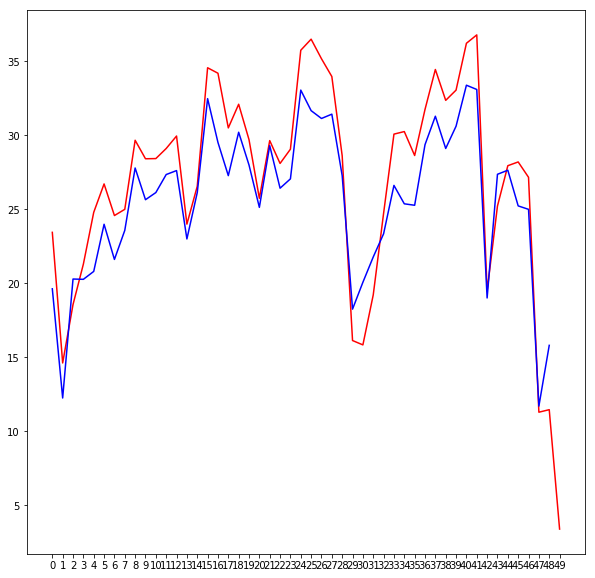

Time Taken :  90.23188972473145
{'R2': 0.69144783227470596, 'MSE': 9.4709239078262453, 'MAE': 2.3788971304694106}


In [38]:
'''
Testing the Neural Network model on df_thermal, where:
df_thermal : full dataframe with consumption values in KWhr.
'''
thermal_dict1 = {}
model_history1 = {}
ti = time.time()
thermal_dict1,y_test1,y_pred1 = nn_model(df_thermal,thermal_dict,1,"mean_squared_error",7,day_hour)
tf = time.time()

print ("Time Taken : ",tf-ti)
print (thermal_dict1)

End i:  1700
Passed the original DataFrame corresponding to the house id : 1632.
                localhour      air1      air2 air3 furnace1 furnace2  \
0  2013-03-23 08:00:00-05         0         0    0  142.417  502.533   
1  2013-03-24 08:00:00-05         0         0    0  4182.12  2967.85   
2  2013-03-25 08:00:00-05      0.15  0.383333    0  10421.1  3787.13   
3  2013-03-26 08:00:00-05         0         0    0  5657.58   2665.9   
4  2013-03-27 08:00:00-05  0.133333         0    0     3477  1465.53   

  waterheater1 total_thermal_load  
0      2567.92            3212.87  
1      1473.55            8623.52  
2      5991.67            20200.4  
3      1437.45            9760.93  
4      4167.75            9110.42  
(1700, 8)
Inside nn :  (1700, 8)
                localhour      air1      air2 air3 furnace1 furnace2  \
0  2013-03-23 08:00:00-05         0         0    0  142.417  502.533   
1  2013-03-24 08:00:00-05         0         0    0  4182.12  2967.85   
2  2013-03-25 08:00:0

1185/1185 [==============================] - 0s - loss: 55588077.9362 - mean_squared_error: 55588077.9362     
Epoch 116/750
1185/1185 [==============================] - 0s - loss: 55249576.6492 - mean_squared_error: 55249576.6492     
Epoch 117/750
1185/1185 [==============================] - 0s - loss: 55243949.1554 - mean_squared_error: 55243949.1554     
Epoch 118/750
1185/1185 [==============================] - 0s - loss: 55260215.8402 - mean_squared_error: 55260215.8402     
Epoch 119/750
1185/1185 [==============================] - 0s - loss: 55138571.6489 - mean_squared_error: 55138571.6489     
Epoch 120/750
1185/1185 [==============================] - 0s - loss: 55274953.7966 - mean_squared_error: 55274953.7966     
Epoch 121/750
1185/1185 [==============================] - 0s - loss: 55195786.8557 - mean_squared_error: 55195786.8557     
Epoch 122/750
1185/1185 [==============================] - 0s - loss: 55653077.7112 - mean_squared_error: 55653077.7112     
Epoch 123/750


1185/1185 [==============================] - 0s - loss: 55524099.1207 - mean_squared_error: 55524099.1207     
Epoch 245/750
1185/1185 [==============================] - 0s - loss: 55190463.9257 - mean_squared_error: 55190463.9257     
Epoch 246/750
1185/1185 [==============================] - 0s - loss: 55547837.1511 - mean_squared_error: 55547837.1511     
Epoch 247/750
1185/1185 [==============================] - 0s - loss: 55248409.7063 - mean_squared_error: 55248409.7063     
Epoch 248/750
1185/1185 [==============================] - 0s - loss: 55031151.5789 - mean_squared_error: 55031151.5789     
Epoch 249/750
1185/1185 [==============================] - 0s - loss: 55006364.0574 - mean_squared_error: 55006364.0574     
Epoch 250/750
1185/1185 [==============================] - 0s - loss: 55435603.7225 - mean_squared_error: 55435603.7225     
Epoch 251/750
1185/1185 [==============================] - 0s - loss: 55516889.7013 - mean_squared_error: 55516889.7013     
Epoch 252/750


1185/1185 [==============================] - 0s - loss: 55109455.5004 - mean_squared_error: 55109455.5004     
Epoch 375/750
1185/1185 [==============================] - 0s - loss: 56419238.1390 - mean_squared_error: 56419238.1390     
Epoch 376/750
1185/1185 [==============================] - 0s - loss: 55117450.6970 - mean_squared_error: 55117450.6970     
Epoch 377/750
1185/1185 [==============================] - 0s - loss: 55202721.5195 - mean_squared_error: 55202721.5195     
Epoch 378/750
1185/1185 [==============================] - 0s - loss: 55029041.3840 - mean_squared_error: 55029041.3840     
Epoch 379/750
1185/1185 [==============================] - 0s - loss: 55191885.4042 - mean_squared_error: 55191885.4042     
Epoch 380/750
1185/1185 [==============================] - 0s - loss: 55106126.7314 - mean_squared_error: 55106126.7314     
Epoch 381/750
1185/1185 [==============================] - 0s - loss: 55018315.0184 - mean_squared_error: 55018315.0184     
Epoch 382/750


1185/1185 [==============================] - 0s - loss: 55015674.6913 - mean_squared_error: 55015674.6913     
Epoch 503/750
1185/1185 [==============================] - 0s - loss: 54921523.3873 - mean_squared_error: 54921523.3873     
Epoch 504/750
1185/1185 [==============================] - 0s - loss: 54913608.6710 - mean_squared_error: 54913608.6710     
Epoch 505/750
1185/1185 [==============================] - 0s - loss: 54993224.0236 - mean_squared_error: 54993224.0236     
Epoch 506/750
1185/1185 [==============================] - 0s - loss: 54865958.2684 - mean_squared_error: 54865958.2684     
Epoch 507/750
1185/1185 [==============================] - 0s - loss: 54801355.9677 - mean_squared_error: 54801355.9677     
Epoch 508/750
1185/1185 [==============================] - 0s - loss: 55000606.2785 - mean_squared_error: 55000606.2785     
Epoch 509/750
1185/1185 [==============================] - 0s - loss: 54964242.6974 - mean_squared_error: 54964242.6974     
Epoch 510/750


1185/1185 [==============================] - 0s - loss: 54957229.0228 - mean_squared_error: 54957229.0228     
Epoch 632/750
1185/1185 [==============================] - 0s - loss: 55206036.2050 - mean_squared_error: 55206036.2050     
Epoch 633/750
1185/1185 [==============================] - 0s - loss: 54818936.3342 - mean_squared_error: 54818936.3342     
Epoch 634/750
1185/1185 [==============================] - 0s - loss: 54724777.2118 - mean_squared_error: 54724777.2118     
Epoch 635/750
1185/1185 [==============================] - 0s - loss: 54812345.5848 - mean_squared_error: 54812345.5848     
Epoch 636/750
1185/1185 [==============================] - 0s - loss: 54773095.3924 - mean_squared_error: 54773095.3924     
Epoch 637/750
1185/1185 [==============================] - 0s - loss: 54879877.1833 - mean_squared_error: 54879877.1833     
Epoch 638/750
1185/1185 [==============================] - 0s - loss: 54911290.3021 - mean_squared_error: 54911290.3021     
Epoch 639/750


/opt/anaconda/lib/python3.6/site-packages/matplotlib/axes/_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


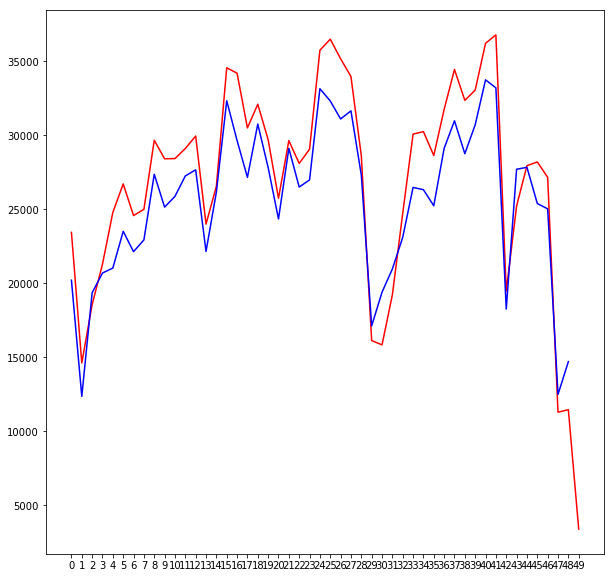

Time Taken :  93.1291275024414
{'R2': 0.6908797778824316, 'MSE': 7237457.9570912169, 'MAE': 1914.2528411965548}


In [100]:
'''
Testing the Neural Network model on df_thermal, where:
df_thermal : full dataframe with consumption values in Watt-hr.
'''
thermal_dict1 = {}
model_history1 = {}
ti = time.time()
thermal_dict1,y_test1,y_pred1 = nn_model(df_new_thermal,thermal_dict,1,"mean_squared_error",7,day_hour)
tf = time.time()

print ("Time Taken : ",tf-ti)
print (thermal_dict1)

In [86]:
'''
Loading all the dataframes into a dictionary, d.
'''

#Dictionary of dataframes.
d = {}

'''
A list containing the house-ids of the houses considered. Only one house has been dropped, due to the presence of 
NaNs in 'air1' , 'furnace1' and 'waterheater1'. 
'''
hid = [1037,115,2401,3268,3273,4000,6324,6614,9912]
for i in range(len(hid)):
    print ("\n\n House : ",hid[i])
    d_total = pd.read_pickle("../DataSets/New_Pecan_Street/load_data_"+str(hid[i])+".pkl")
    d_total.isnull().sum()
    
    #Selecting only the attributes, which are common to all the houses.
    d_total = d_total[["localhour","air1","furnace1","waterheater1"]]
    
    #Converting the consumption values from 'KWhr' to 'Watthr'.
    d_total.iloc[:,[1,2,3]] = d_total.iloc[:,[1,2,3]].mul(1000)
    d[hid[i]] = d_total



 House :  1037


 House :  115


 House :  2401


 House :  3268


 House :  3273


 House :  4000


 House :  6324


 House :  6614


 House :  9912


In [89]:
#Sanity Check.
d[1037].head()

,localhour,air1,furnace1,waterheater1
0,2014-02-07 19:00:00-06,0.0,0.000000,146.233333
1,2014-02-07 20:00:00-06,0.0,2200.100000,0.000000
2,2014-02-07 21:00:00-06,0.0,1313.366667,0.000000
3,2014-02-07 22:00:00-06,0.0,34.600000,0.000000
4,2014-02-07 23:00:00-06,0.0,0.000000,151.000000


In [ ]:
'''
Whatever follows below, is INCONSEQUENTIAL.
'''

In [ ]:
'''
Moving on to 'Extra Trees Regresssor.
'''
def et_month(localdf):
    scores=[]
    for i in range(len(localdf.columns)):
                df = pd.DataFrame()
                if(i != 0):
                    #print(localdf.columns[i])
                    df = localdf[localdf.columns[i]]
                    ndf = pd.concat([df.shift(168), df.shift(24), df], axis=1)
                    ndf.columns = ('t-168', 't-24', 't')
                    ndf = ndf.iloc[168:]

                    x = ndf[ndf.columns[0:2]]
                    y = ndf[ndf.columns[-1:]]
                    
                    #Sequential Split.
                    train_size = int(70*x.shape[0]/100)
                    X_train = x.values[:train_size]
                    y_train = y.values[:train_size]
                    
                    X_test = x.values[train_size:]
                    y_test = y.values[train_size:]
                    
                    print (X_train.shape,y_train.shape)
                    print (X_test.shape,y_test.shape)
                    #X_train,X_test,y_train,y_test = train_test_split(x.values,y.values,test_size=0.2,random_state=1)

                    model = ExtraTreeRegressor()
                    model = model.fit(X_train,y_train)
                    y_pred = model.predict(X_test)
                    #scores.append(r2_score(y_test,y_pred))
                    scores.append(m.mean_squared_error(y_test,y_pred))
                    #scores.append(cross_val_score(model,x.values,y.values,scoring='r2',cv=2))
    return scores          

In [ ]:
'''
Moving on to 'Extra Trees Regresssor.
'''
def et_2hours(localdf):
    scores=[]
    for i in range(len(localdf.columns)):
                df = pd.DataFrame()
                if(i != 0):
                    #print(localdf.columns[i])
                    df = localdf[localdf.columns[i]]
                    ndf = pd.concat([df.shift(2), df.shift(1), df], axis=1)
                    ndf.columns = ('t-2', 't-1', 't')
                    ndf = ndf.iloc[2:]

                    x = ndf[ndf.columns[0:2]]
                    y = ndf[ndf.columns[-1:]]
                    
                    #Sequential Split.
                    train_size = int(70*x.shape[0]/100)
                    X_train = x.values[:train_size]
                    y_train = y.values[:train_size]
                    
                    X_test = x.values[train_size:]
                    y_test = y.values[train_size:]
                    
                    print (X_train.shape,y_train.shape)
                    print (X_test.shape,y_test.shape)
                    #X_train,X_test,y_train,y_test = train_test_split(x.values,y.values,test_size=0.2,random_state=1)

                    model = ExtraTreeRegressor()
                    model = model.fit(X_train,y_train)
                    y_pred = model.predict(X_test)
                    #scores.append(r2_score(y_test,y_pred))
                    scores.append(m.mean_squared_error(y_test,y_pred))
                    #scores.append(cross_val_score(model,x.values,y.values,scoring='r2',cv=2))
    return scores          

In [ ]:
'''
Moving on to 'Extra Trees Regresssor.
'''
def et_4hours(localdf):
    scores=[]
    for i in range(len(localdf.columns)):
                df = pd.DataFrame()
                if(i != 0):
                    #print(localdf.columns[i])
                    df = localdf[localdf.columns[i]]
                    ndf = pd.concat([df.shift(4),df.shift(3),df.shift(2), df.shift(1), df], axis=1)
                    ndf.columns = ('t-4','t-3','t-2', 't-1', 't')
                    ndf = ndf.iloc[4:]

                    x = ndf[ndf.columns[0:4]]
                    y = ndf[ndf.columns[-1:]]
                    
                    #Sequential Split.
                    train_size = int(70*x.shape[0]/100)
                    X_train = x.values[:train_size]
                    y_train = y.values[:train_size]

                    X_test = x.values[train_size:]
                    y_test = y.values[train_size:]
                    
                    print (X_train.shape,y_train.shape)
                    print (X_test.shape,y_test.shape)
                    
                    #X_train,X_test,y_train,y_test = train_test_split(x.values,y.values,test_size=0.2,random_state=1)

                    model = ExtraTreeRegressor()
                    model = model.fit(X_train,y_train)
                    y_pred = model.predict(X_test)
                    #scores.append(r2_score(y_test,y_pred))
                    scores.append(m.mean_squared_error(y_test,y_pred))
                    #scores.append(cross_val_score(model,x.values,y.values,scoring='r2',cv=2))
    return scores          

In [ ]:
#Metric : 'r^2'.
scores_2hours = et_2hours(df_thermal)
print (scores_2hours)

In [ ]:
#Metric : 'r^2'.
scores_4hours = et_4hours(df_thermal)
print (scores_4hours)

In [ ]:
#Metric : 'r^2'.
scores_month = et_month(df_thermal)
print (scores_month)

In [ ]:
#Metric : 'mse'.
scores_2hours = et_2hours(df_thermal)
print (scores_2hours)

In [ ]:
#Metric : 'mse'.
scores_4hours = et_4hours(df_thermal)
print (scores_4hours)

In [ ]:
df_thermal.head(10)

In [ ]:
df_thermal.to_csv("df_thermal.csv",encoding="utf8")

In [ ]:
for i in df_thermal.columns:
    print (np.amax(df_thermal[i]))

In [ ]:
df_thermal.shape

In [ ]:
df_thermal.head(50)

In [ ]:
days = ['Saturday','Sunday','Monday','Tuesday','Wednesday','Thursday','Friday']
columns = np.empty([df_thermal.shape[0],1],dtype=str)
i=0
while i <= (df_thermal.shape[0]-7):
    columns[i]   = 'Saturday'
    columns[i+1] = 'Sunday'
    columns[i+2] = 'Monday'
    columns[i+3] = 'Tuesday'
    columns[i+4] = 'Wednesday'
    columns[i+5] = 'Thursday'
    columns[i+6] = 'Friday'
    i += 7

In [ ]:
print (columns[0])

In [ ]:
plt.plot(df_thermal.values[:,1:])
plt.show()

In [ ]:
for i in range(df_thermal.columns.shape[0]):    
    print ("\nMAX,MIN: ",np.max(df_thermal.values[:,i])," ",np.min(df_thermal.values[:,i]) )

In [ ]:
d1 = pd.DataFrame(new_df1[:50,0])

In [ ]:
d2 = pd.DataFrame(new_df1[:50,4:6])

In [ ]:
d = pd.concat([d1,d2],axis=1)
d.columns = [df_thermal.columns[0],df_thermal.columns[4],df_thermal.columns[5]]
d.head()

In [ ]:
d_total = pd.DataFrame(df_thermal)
d_total.shape

In [ ]:
np.amax(d_total)

In [ ]:
unique_1 , counts_1 = np.unique(d_total.values[:,4],return_counts=True)
unique_2 , counts_2 = np.unique(d_total.values[:,5],return_counts=True)

In [ ]:
dict_count1 = dict(zip(unique_1,counts_1))
dict_count2 = dict(zip(unique_2,counts_2))
print ("Count of 0's : ",dict_count1[0],dict_count2[0])
print ("Count of 5's : ",dict_count1[5],dict_count2[10])

In [ ]:
print (np.sum(d_total.values[:,4]==6))
print (np.sum(d_total.values[:,5]==10))

In [ ]:
'''
8*7
23*7
'''
thermal_dict1 = {}
model_history1 = {}
ti = time.time()
thermal_dict1,y_test1,y_pred1 = nn_model(df_thermal,thermal_dict,1,"mean_squared_error",7,day_hour,56,161)
tf = time.time()
print ("Time Taken : ",tf-ti)
print (thermal_dict1)

In [ ]:
d_total.values[(np.where(d_total.values[:,4] == 5)[0])]

In [ ]:
plt.hist((df_thermal.values[:,4]),bins=100)
plt.show()

In [ ]:
np.mean(df_thermal.values[:,4])

In [ ]:
new_df1.shape

In [ ]:
plt.title("Furnace 1")
plt.hist((new_df1[:,4]),bins=100)
plt.show()

In [ ]:
plt.title("Furnace 2")
plt.hist((new_df1[:,5]),bins=100)
plt.show()

In [127]:
df_new_thermal.columns

Index(['localhour', 'air1', 'air2', 'air3', 'furnace1', 'furnace2',
       'waterheater1', 'total_thermal_load'],
      dtype='object')

In [151]:
df_thermal.head()

,localhour,air1,air2,air3,furnace1,furnace2,waterheater1,total_thermal_load
0,2013-03-23 08:00:00-05,0,0,0,0.0059,0.01,0,0.0159
1,2013-03-23 09:00:00-05,0,0,0,0.00491667,0.01,0,0.0149167
2,2013-03-23 10:00:00-05,0,0,0,0.0059,0.0762833,0.181567,0.26375
3,2013-03-23 11:00:00-05,0,0,0,0.0059,0.0760333,1.32477,1.4067
4,2013-03-23 12:00:00-05,0,0,0,0.006,0.01,0,0.016


In [205]:
new_df1 = pd.DataFrame(new_df1)
new_df1.head()

,localhour,air1,air2,air3,furnace1,furnace2,waterheater1,total_thermal_load
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [134]:
new_df1['weekday'] = pd.to_datetime(new_df1['localhour']).dt.dayofweek
new_df1['month'] = pd.to_datetime(new_df1['localhour']).dt.month

In [136]:
new_df1.tail()

,localhour,air1,furnace1,waterheater1,total_thermal_load,weekday,month
1695,2017-11-12 07:00:00-06,0,120.267,820.217,940.483,6,11
1696,2017-11-13 07:00:00-06,0,120,1215.93,1335.93,0,11
1697,2017-11-14 07:00:00-06,0,120.183,823.233,943.417,1,11
1698,2017-11-15 07:00:00-06,0,120.15,1234.83,1354.98,2,11
1699,2017-11-16 07:00:00-06,0,120.167,823.267,943.433,3,11
